In [1]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from astropy.table import Table

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)



Device: cpu


In [2]:
import os
import pandas as pd
from astropy.table import Table

# Load the main catalog
cat_dir = "/Users/marchuertascompany/Documents/data/COSMOS-Web/cats"
cat_name = "COSMOSWeb_master_v2.0.1-sersic-cgs_LePhare-v2_FlaggedM.fits"
cat_cosmos = Table.read(os.path.join(cat_dir, cat_name), format='fits')
names = [name for name in cat_cosmos.colnames if len(cat_cosmos[name].shape) <= 1]
cat = cat_cosmos[names].to_pandas()

# Define a function to load and merge a prediction catalog
def merge_with_predictions(cat, pred_path, filter_name):
    pred = pd.read_csv(pred_path)
    pred = pred.add_suffix(f'_{filter_name}')
    pred.rename(columns={f'id_{filter_name}': 'id_str'}, inplace=True)
    merged = cat.merge(pred, how='inner', right_on=f'id_str', left_on='Id', suffixes=(None, f'_{filter_name}'))
    return merged

# Paths to the prediction catalogs - CHANGE PATHS WHEN DOWNLOADED
pred_paths = {
    'f150w': "/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot/bars_COSMOS_f277w_effnet_m27_sampling.csv",
    'f277w': "/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot/bars_COSMOS_f277w_effnet_m27_sampling.csv",
    'f444w': "/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot/bars_COSMOS_f444w_effnet_m27_sampling.csv"
}

# Merge with each prediction catalog
merged_cat = cat.copy()
for filter_name, pred_path in pred_paths.items():
    merged_cat = merge_with_predictions(merged_cat, pred_path, filter_name)

# Remove redundant 'id_str' columns after merging
for filter_name in pred_paths.keys():
    col_name = f'id_str_{filter_name}'
    if col_name in merged_cat.columns:
        merged_cat.drop(columns=[col_name], inplace=True)

# Final merged catalog
merge = merged_cat

# Display the merged catalog
print(merge.head())


   Id    RA_DETEC  DEC_DETEC    RA_MODEL  DEC_MODEL        X_TILE      Y_TILE  \
0   2  149.863180   2.497745  149.863391   2.497355  17710.748047   17.120798   
1   8  149.866700   2.497064  149.866714   2.497059  17286.269531   84.545654   
2  10  149.938853   2.472919  149.938848   2.472913   8166.365723  318.987549   
3  11  149.929907   2.474917  149.929863   2.474854   9256.284180  177.657639   
4  12  149.930622   2.475213  149.930619   2.475138   9187.951172  240.293930   

     AREA    RADIUS    RADIUS_err  ...  id_str  \
0  9672.0  0.000262  5.857034e-06  ...       2   
1   112.0  0.000060  1.088756e-06  ...       8   
2   102.0  0.000042  2.236739e-06  ...      10   
3   207.0  0.000101  3.648799e-07  ...      11   
4   735.0  0.000185  1.507509e-06  ...      12   

                                 feature_count_f150w  \
0  [26, 26, 28,  5,  9, 38, 10, 24, 20, 28, 43, 2...   
1  [28, 19, 51, 15, 28, 25, 22, 38, 54, 38, 21, 2...   
2  [13, 14, 17, 12, 20, 22, 15, 11, 21, 30, 

In [86]:
import numpy as np
import pandas as pd
import re

N_VOLS = 100
n_samples=100

# Function to parse and clean count arrays from string representation
def parse_count_array(count_str):
    # Remove all non-numeric characters except for commas
    clean_str = re.sub(r'[^\d,]', '', count_str)
    # Split the cleaned string by commas
    return np.array([int(x) for x in clean_str.split(',')])

# Vectorized function to calculate probabilities for all samples in a column
def calculate_probabilities_feature(df, count_column, n_vols):
    return df[count_column].apply(lambda x: parse_count_array(x) / n_vols)

def calculate_probabilities_edge(df, count_column, nvols_column):
    return df.apply(lambda row: parse_count_array(row[count_column]) / parse_count_array(row[nvols_column]), axis=1)

def calculate_probabilities_bar(df, count_column, nfeature_column,nedge_column):
    return df.apply(lambda row: parse_count_array(row[count_column]) / (parse_count_array(row[nfeature_column])-parse_count_array(row[nedge_column])), axis=1)

# Calculate probabilities for each filter and store them in the DataFrame
merge['p_feature_f150w'] = calculate_probabilities_feature(merge, 'feature_count_f150w', np.zeros(n_samples)+N_VOLS)
merge['p_edgeon_f150w'] = calculate_probabilities_edge(merge, 'edgeon_count_f150w','feature_count_f150w')
merge['p_bar_f150w'] = calculate_probabilities_bar(merge, 'bar_count_f150w', 'feature_count_f150w','edgeon_count_f150w')


merge['p_feature_f277w'] = calculate_probabilities_feature(merge, 'feature_count_f277w', np.zeros(n_samples)+N_VOLS)
merge['p_edgeon_f277w'] = calculate_probabilities_edge(merge, 'edgeon_count_f277w', 'feature_count_f277w')
merge['p_bar_f277w'] = calculate_probabilities_bar(merge, 'bar_count_f277w', 'feature_count_f150w','edgeon_count_f150w')


merge['p_feature_f444w'] = calculate_probabilities_feature(merge, 'feature_count_f444w', np.zeros(n_samples)+N_VOLS)
merge['p_edgeon_f444w'] = calculate_probabilities_edge(merge, 'edgeon_count_f444w', 'feature_count_f444w')
merge['p_bar_f444w'] = calculate_probabilities_bar(merge, 'bar_count_f444w', 'feature_count_f150w','edgeon_count_f150w')


# Function to select the correct probabilities based on redshift conditions
def select_probabilities(row):
    conditions = [row['LP_zfinal'] < 1, 1 <= row['LP_zfinal'] < 3, row['LP_zfinal'] >= 3]
    p_feature_choices = [row['p_feature_f150w'], row['p_feature_f277w'], row['p_feature_f444w']]
    p_bar_choices = [row['p_bar_f150w'], row['p_bar_f277w'], row['p_bar_f444w']]
    p_edgeon_choices = [row['p_edgeon_f150w'], row['p_edgeon_f277w'], row['p_edgeon_f444w']]
    #rf_mag_choices = [row['MAG_MODEL_F150W'], row['MAG_MODEL_F277W'] - 0.6, row['MAG_MODEL_F444W'] - 0.5]

    return (
        np.select(conditions, p_feature_choices, default=np.nan),
        np.select(conditions, p_bar_choices, default=np.nan),
        np.select(conditions, p_edgeon_choices, default=np.nan),
        #np.select(conditions, rf_mag_choices, default=np.nan)  # Return single value for RF_mag_samples
    )

# Apply the function to each row and store the results
merge[['p_feature_samples', 'p_bar_samples', 'p_edgeon_samples']] = merge.apply(
    lambda row: pd.Series(select_probabilities(row)), axis=1
)

#rf_mag_choices = [row['MAG_MODEL_F150W'], row['MAG_MODEL_F277W'] - 0.6, row['MAG_MODEL_F444W'] - 0.5]
rf_mag = merge.MAG_MODEL_F150W.values
z=merge.LP_zfinal.values
rf_mag[(z>1)&(z<3)]=merge.MAG_MODEL_F277W.values[(z>1)&(z<3)]-0.6
rf_mag[(z>3)]=merge.MAG_MODEL_F444W.values[(z>3)]-0.5

merge['RF_mag']=rf_mag

# Display the updated DataFrame with the new columns
print(merge[['LP_zfinal', 'p_feature_samples', 'p_bar_samples', 'RF_mag', 'p_edgeon_samples']].head())


   LP_zfinal                                  p_feature_samples  \
0     1.7603  [0.26, 0.26, 0.28, 0.05, 0.09, 0.38, 0.1, 0.24...   
1     1.2705  [0.28, 0.19, 0.51, 0.15, 0.28, 0.25, 0.22, 0.3...   
2     0.5977  [0.13, 0.14, 0.17, 0.12, 0.2, 0.22, 0.15, 0.11...   
3     0.9186  [0.1, 0.09, 0.04, 0.13, 0.36, 0.18, 0.12, 0.13...   
4     1.9673  [0.72, 0.74, 0.69, 0.72, 0.63, 0.64, 0.6, 0.73...   

                                       p_bar_samples     RF_mag  \
0  [0.3, 0.2916666666666667, 0.2631578947368421, ...  18.163360   
1  [0.3333333333333333, 0.1875, 0.085714285714285...  25.394156   
2  [0.16666666666666666, 0.23076923076923078, 0.2...  26.472796   
3  [0.2, 0.375, 0.5, 0.3333333333333333, 0.25, 0....  21.984324   
4  [0.2153846153846154, 0.421875, 0.1159420289855...  22.878903   

                                    p_edgeon_samples  
0  [0.23076923076923078, 0.07692307692307693, 0.3...  
1  [0.25, 0.15789473684210525, 0.3137254901960784...  
2  [0.07692307692307693, 0.07

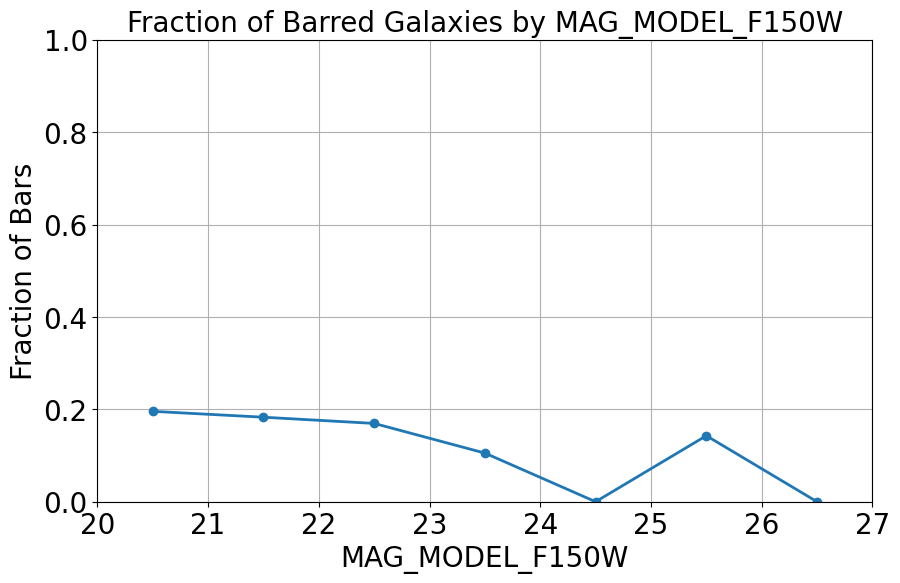

In [255]:
# OLD CELL - DO NOT USE #select bars

bars_lz = merge.query('LP_zfinal<1.5 and LP_mass_med_PDF>10 and AXRATIO>0.5 and p_bar>0.5 and p_feature>0.5')
disks_lz = merge.query('LP_zfinal<1.5 and LP_mass_med_PDF>10  and AXRATIO>0.5 and p_feature>0.5')

m150_disks = disks_lz.RF_mag.values
m150_bars = bars_lz.RF_mag.values


bars_hz = merge.query('LP_zfinal>2 and LP_zfinal<3 and LP_mass_med_PDF>10 and LP_mass_med_PDF<11 and AXRATIO>0.5 and p_bar>0.5 and p_feature>0.5')
disks_hz = merge.query('LP_zfinal>2 and LP_zfinal<3 and LP_mass_med_PDF>10 and AXRATIO>0.5 and p_feature>0.5')

m150_disks = disks_lz.RF_mag.values
m150_bars = bars_lz.RF_mag.values


bins = np.arange(20, 28, 1)

# Histogram the data into these bins
hist_disks, _ = np.histogram(m150_disks, bins=bins)
hist_bars, _ = np.histogram(m150_bars, bins=bins)

# Calculate the fraction of bars
total = hist_disks + hist_bars
fraction_bars = np.divide(hist_bars, total, where=total!=0)  # Avoid division by zero

# Bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, fraction_bars, marker='o', linestyle='-', linewidth=2)
plt.xlabel('MAG_MODEL_F150W', fontsize=20)
plt.ylabel('Fraction of Bars', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([20, 27])
plt.ylim([0, 1])  # Fraction ranges from 0 to 1
plt.grid(True)
plt.title('Fraction of Barred Galaxies by MAG_MODEL_F150W', fontsize=20)
plt.show()


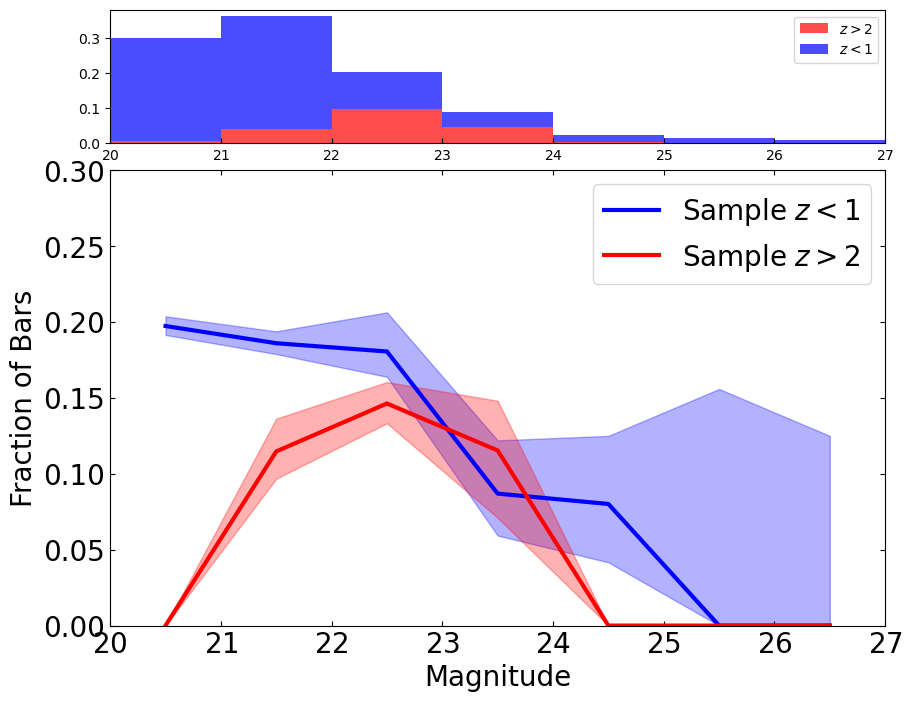

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

# Ensure the bins are defined
bins = np.arange(20, 28, 1)
bin_centers = (bins[:-1] + bins[1:]) / 2
N_VOLS = 100

# Function to calculate fractions and plot
def calculate_fractions_and_plot(merge, ax, label, color):
    fractions_lz = []
    fractions_hz = []

    for i in range(N_VOLS):
        # Apply the conditions manually for each sample
        bars_lz = merge[(merge['LP_zfinal'] < 1.5) & 
                        (merge['LP_mass_med_PDF'] > 10) & 
                        (merge['LP_mass_med_PDF'] < 11) &
                        (merge['AXRATIO'] > 0.5) & 
                        (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                        (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        disks_lz = merge[(merge['LP_zfinal'] < 1.5) & 
                         (merge['LP_mass_med_PDF'] > 10) & 
                         (merge['LP_mass_med_PDF'] < 11) &
                         (merge['AXRATIO'] > 0.5) & 
                         (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

        bars_hz = merge[(merge['LP_zfinal'] > 2) & 
                        (merge['LP_zfinal'] < 3) & 
                        (merge['LP_mass_med_PDF'] > 10) & 
                        (merge['LP_mass_med_PDF'] < 11) & 
                        (merge['AXRATIO'] > 0.5) & 
                        (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                        (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        disks_hz = merge[(merge['LP_zfinal'] > 2) & 
                         (merge['LP_zfinal'] < 3) & 
                         (merge['LP_mass_med_PDF'] > 10) & 
                         (merge['LP_mass_med_PDF'] < 11) &
                         (merge['AXRATIO'] > 0.5) & 
                         (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

        # Use corresponding magnitude values for disks and bars
        m_disks_lz = disks_lz['RF_mag'].values
        m_bars_lz = bars_lz['RF_mag'].values
        m_disks_hz = disks_hz['RF_mag'].values
        m_bars_hz = bars_hz['RF_mag'].values

        # Calculate histograms for disks and bars in each redshift range
        hist_disks_lz, _ = np.histogram(m_disks_lz, bins=bins)
        hist_bars_lz, _ = np.histogram(m_bars_lz, bins=bins)
        hist_disks_hz, _ = np.histogram(m_disks_hz, bins=bins)
        hist_bars_hz, _ = np.histogram(m_bars_hz, bins=bins)

        # Calculate the fraction of bars
        total_lz = hist_disks_lz + hist_bars_lz
        fraction_bars_lz = np.divide(hist_bars_lz, total_lz, out=np.zeros_like(hist_bars_lz, dtype=float), where=total_lz != 0)
        total_hz = hist_disks_hz + hist_bars_hz
        fraction_bars_hz = np.divide(hist_bars_hz, total_hz, out=np.zeros_like(hist_bars_hz, dtype=float), where=total_hz != 0)

        fractions_lz.append(fraction_bars_lz)
        fractions_hz.append(fraction_bars_hz)

        # Plot individual lines with alpha=0.8
        #ax.plot(bin_centers, fraction_bars_lz, marker='o', linestyle='-', linewidth=1, alpha=0.8, color=color)
        #ax.plot(bin_centers, fraction_bars_hz, marker='o', linestyle='-', linewidth=1, alpha=0.8, color=color)

    fractions_lz = np.array(fractions_lz)
    fractions_hz = np.array(fractions_hz)

    # Compute median and 1-sigma scatter for low-z and high-z
    median_fraction_lz = np.nanmedian(fractions_lz, axis=0)
    lower_bound_lz = np.nanpercentile(fractions_lz, 16, axis=0)
    upper_bound_lz = np.nanpercentile(fractions_lz, 84, axis=0)

    median_fraction_hz = np.nanmedian(fractions_hz, axis=0)
    lower_bound_hz = np.nanpercentile(fractions_hz, 16, axis=0)
    upper_bound_hz = np.nanpercentile(fractions_hz, 84, axis=0)

    # Plot median and scatter with solid lines and shaded region
    ax.plot(bin_centers, median_fraction_lz, linestyle='-', linewidth=3, label=label + ' $z<1$', color='blue')
    ax.fill_between(bin_centers, lower_bound_lz, upper_bound_lz, color='blue', alpha=0.3)

    ax.plot(bin_centers, median_fraction_hz, linestyle='-', linewidth=3, label=label + ' $z>2$', color='red')
    ax.fill_between(bin_centers, lower_bound_hz, upper_bound_hz, color='red', alpha=0.3)

# Create figure and specify grid layout
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 4, figure=fig)

# Main plot for fractions
ax_main = fig.add_subplot(gs[1:4, :])
ax_histx = fig.add_subplot(gs[0, :], sharex=ax_main)

# Plot low-z and high-z data
calculate_fractions_and_plot(merge, ax_main, 'Sample', 'blue')

# Set labels and limits
ax_main.set_xlabel('Magnitude', fontsize=20)
ax_main.set_ylabel('Fraction of Bars', fontsize=20)
ax_main.set_xlim([20, 27])
ax_main.set_ylim([0, .3])
ax_main.legend(fontsize=20)
ax_main.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
ax_histx.tick_params(axis='x', which='both', direction='in')

# Enable scientific notation
ax_main.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax_histx.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

# Plot filled histograms on top
ax_histx.hist([merge.query('LP_zfinal>2 and LP_zfinal<3 and AXRATIO>0.5 and LP_mass_med_PDF>10')['RF_mag'].values,
               merge.query('LP_zfinal<1.5 and AXRATIO>0.5 and LP_mass_med_PDF>10')['RF_mag'].values], 
              bins=bins, label=['$z>2$', '$z<1$'], color=['red', 'blue'], alpha=0.7, stacked=True, density=True)

# Adding legend to histograms
ax_histx.legend(loc='upper right')

plt.show()


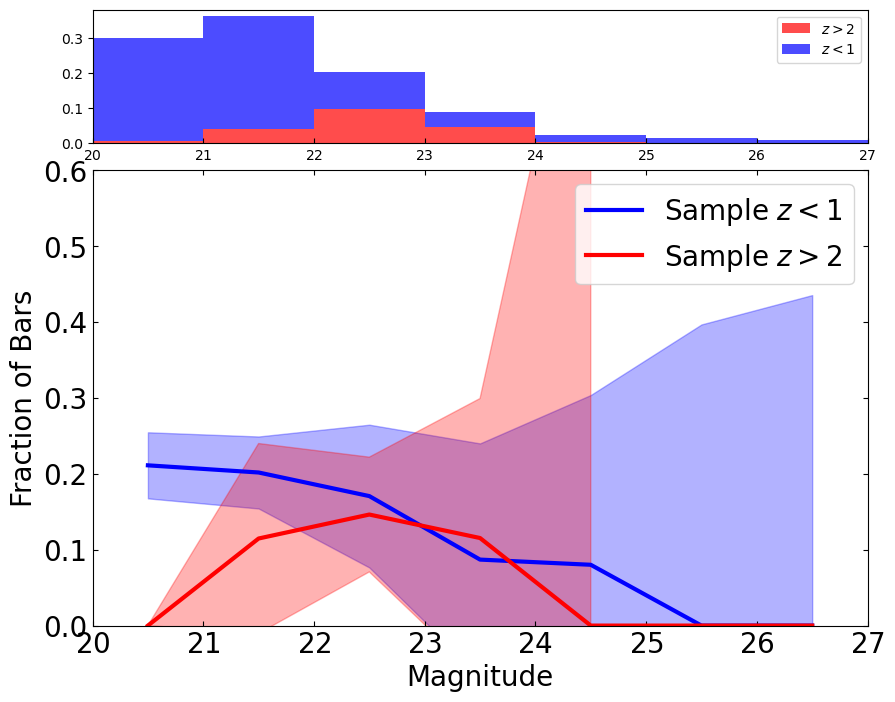

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

# Ensure the bins are defined
bins = np.arange(20, 28, 1)
bin_centers = (bins[:-1] + bins[1:]) / 2
N_VOLS = 100

# Function to calculate fractions and plot
def calculate_fractions_and_plot(merge, ax, label, color):
    fractions_lz = []
    fractions_hz = []
    total_hist_lz = []
    total_hist_hz = []
    fbar_hz=[]
    fbar_lz=[]

    for i in range(N_VOLS):
        # Apply the conditions manually for each sample
        bars_lz = merge[(merge['LP_zfinal'] < 1.) & 
                        (merge['LP_mass_med_PDF'] > 10) & 
                        (merge['LP_mass_med_PDF'] < 11) &
                        (merge['AXRATIO'] > 0.5) & 
                        (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                        (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        disks_lz = merge[(merge['LP_zfinal'] < 1.) & 
                         (merge['LP_mass_med_PDF'] > 10) & 
                         (merge['LP_mass_med_PDF'] < 11) &
                         (merge['AXRATIO'] > 0.5) & 
                         (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

        bars_hz = merge[(merge['LP_zfinal'] > 2) & 
                        (merge['LP_zfinal'] < 3) & 
                        (merge['LP_mass_med_PDF'] > 10) & 
                        (merge['LP_mass_med_PDF'] < 11) & 
                        (merge['AXRATIO'] > 0.5) & 
                        (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                        (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        disks_hz = merge[(merge['LP_zfinal'] > 2) & 
                         (merge['LP_zfinal'] < 3) & 
                         (merge['LP_mass_med_PDF'] > 10) & 
                         (merge['LP_mass_med_PDF'] < 11) &
                         (merge['AXRATIO'] > 0.5) & 
                         (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

        fbar_hz.append(len(bars_hz)/len(disks_hz))
        fbar_lz.append(len(bars_lz)/len(disks_lz))


        # Use corresponding magnitude values for disks and bars
        m_disks_lz = disks_lz['RF_mag'].values
        m_bars_lz = bars_lz['RF_mag'].values
        m_disks_hz = disks_hz['RF_mag'].values
        m_bars_hz = bars_hz['RF_mag'].values

        # Calculate histograms for disks and bars in each redshift range
        hist_disks_lz, _ = np.histogram(m_disks_lz, bins=bins)
        hist_bars_lz, _ = np.histogram(m_bars_lz, bins=bins)
        hist_disks_hz, _ = np.histogram(m_disks_hz, bins=bins)
        hist_bars_hz, _ = np.histogram(m_bars_hz, bins=bins)

        # Calculate the fraction of bars
        total_lz = hist_disks_lz + hist_bars_lz
        fraction_bars_lz = np.divide(hist_bars_lz, total_lz, out=np.zeros_like(hist_bars_lz, dtype=float), where=total_lz != 0)
        total_hz = hist_disks_hz + hist_bars_hz
        fraction_bars_hz = np.divide(hist_bars_hz, total_hz, out=np.zeros_like(hist_bars_hz, dtype=float), where=total_hz != 0)

        fractions_lz.append(fraction_bars_lz)
        fractions_hz.append(fraction_bars_hz)
        total_hist_lz.append(total_lz)
        total_hist_hz.append(total_hz)

    fractions_lz = np.array(fractions_lz)
    fractions_hz = np.array(fractions_hz)
    total_hist_lz = np.array(total_hist_lz)
    total_hist_hz = np.array(total_hist_hz)

    # Compute median and 1-sigma scatter for low-z and high-z
    median_fraction_lz = np.nanmedian(fractions_lz, axis=0)
    lower_bound_lz = np.nanpercentile(fractions_lz, 16, axis=0)
    upper_bound_lz = np.nanpercentile(fractions_lz, 84, axis=0)

    median_fraction_hz = np.nanmedian(fractions_hz, axis=0)
    lower_bound_hz = np.nanpercentile(fractions_hz, 16, axis=0)
    upper_bound_hz = np.nanpercentile(fractions_hz, 84, axis=0)

    # Calculate Poisson errors for the histograms
    poisson_errors_lz = np.sqrt(np.nanmedian(total_hist_lz, axis=0))
    poisson_errors_hz = np.sqrt(np.nanmedian(total_hist_hz, axis=0))

    # Combine errors in quadrature
    combined_errors_lz = np.sqrt((upper_bound_lz - median_fraction_lz) ** 2 + (poisson_errors_lz / total_hist_lz.mean(axis=0)) ** 2)
    combined_errors_hz = np.sqrt((upper_bound_hz - median_fraction_hz) ** 2 + (poisson_errors_hz / total_hist_hz.mean(axis=0)) ** 2)

    # Plot median and scatter with solid lines and shaded region
    ax.plot(bin_centers, median_fraction_lz, linestyle='-', linewidth=3, label=label + ' $z<1$', color='blue')
    ax.fill_between(bin_centers, median_fraction_lz - combined_errors_lz, median_fraction_lz + combined_errors_lz, color='blue', alpha=0.3)

    ax.plot(bin_centers, median_fraction_hz, linestyle='-', linewidth=3, label=label + ' $z>2$', color='red')
    ax.fill_between(bin_centers, median_fraction_hz - combined_errors_hz, median_fraction_hz + combined_errors_hz, color='red', alpha=0.3)

    return fbar_lz,fbar_hz

# Create figure and specify grid layout
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 4, figure=fig)

# Main plot for fractions
ax_main = fig.add_subplot(gs[1:4, :])
ax_histx = fig.add_subplot(gs[0, :], sharex=ax_main)

# Plot low-z and high-z data
fbar_lz,fbar_hz=calculate_fractions_and_plot(merge, ax_main, 'Sample', 'blue')

# Set labels and limits
ax_main.set_xlabel('Magnitude', fontsize=20)
ax_main.set_ylabel('Fraction of Bars', fontsize=20)
ax_main.set_xlim([20, 27])
ax_main.set_ylim([0, .6])
ax_main.legend(fontsize=20)
ax_main.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
ax_histx.tick_params(axis='x', which='both', direction='in')

# Enable scientific notation
ax_main.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax_histx.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

# Plot filled histograms on top
ax_histx.hist([merge.query('LP_zfinal>2 and LP_zfinal<3 and AXRATIO>0.5 and LP_mass_med_PDF>10')['RF_mag'].values,
               merge.query('LP_zfinal<1.5 and AXRATIO>0.5 and LP_mass_med_PDF>10')['RF_mag'].values], 
              bins=bins, label=['$z>2$', '$z<1$'], color=['red', 'blue'], alpha=0.7, stacked=True, density=True)

# Adding legend to histograms
ax_histx.legend(loc='upper right')

plt.show()


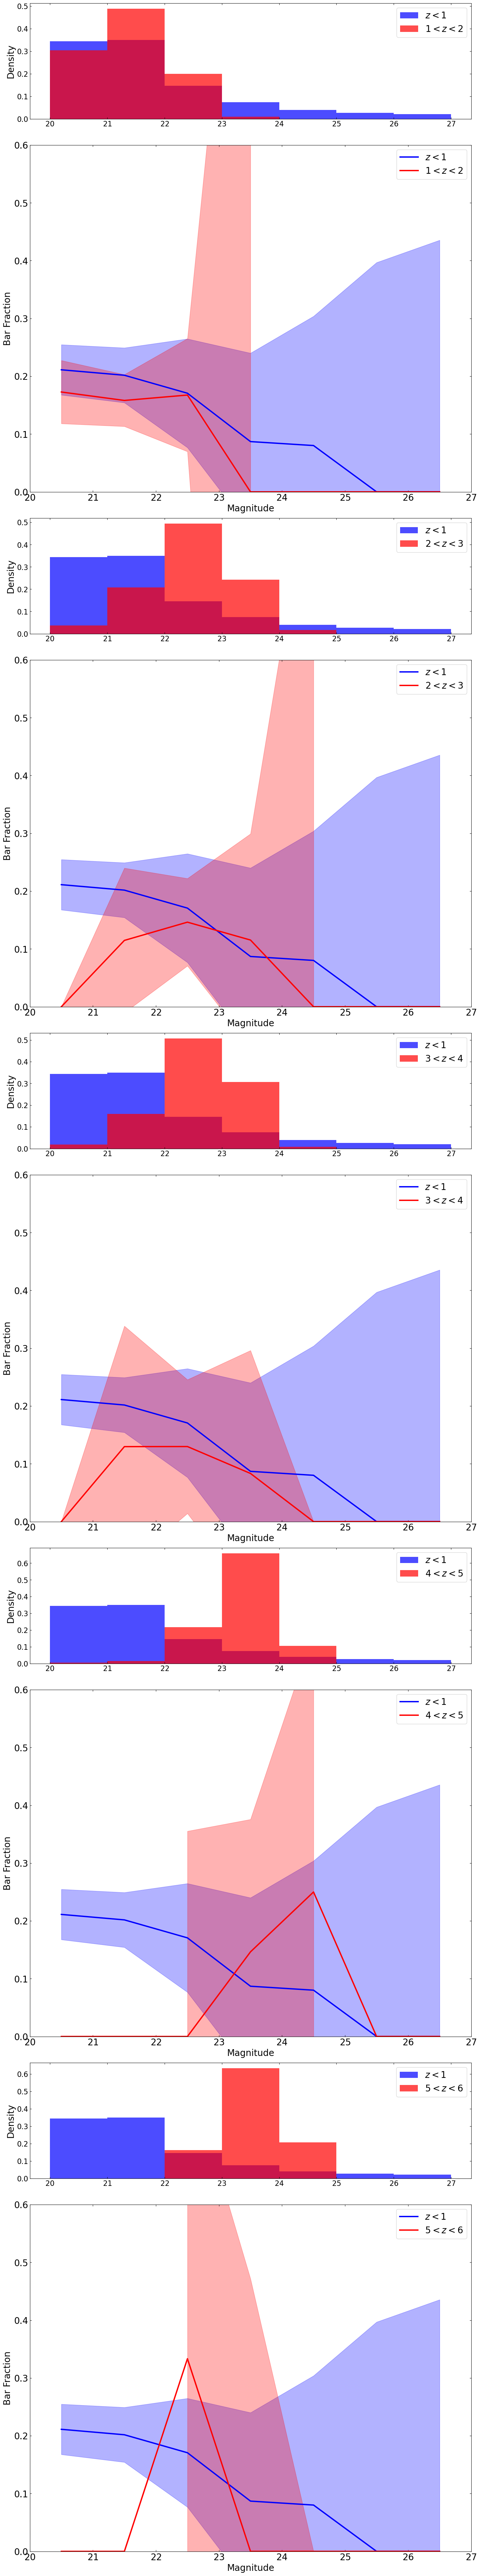

z<1: [0.2849002849002849, 0.27608232789212206, 0.27871148459383754, 0.27155172413793105, 0.2642706131078224, 0.279337652987761, 0.26498194945848375, 0.27605633802816903, 0.2824372759856631, 0.26799714896650034, 0.2656359803232607, 0.2756640344580043, 0.2542372881355932, 0.27339719970523213, 0.296987087517934, 0.26934306569343064, 0.2756183745583039, 0.2631205673758865, 0.2694781987133667, 0.2574762946754194, 0.294826364280652, 0.2762784090909091, 0.270935960591133, 0.2678445229681979, 0.2668082094833687, 0.27789623312011374, 0.26836363636363636, 0.27325581395348836, 0.27350427350427353, 0.26176890156918686, 0.2631959508315257, 0.2698986975397974, 0.27279102384291726, 0.26178390137781, 0.2576419213973799, 0.2647482014388489, 0.2695035460992908, 0.27753934191702434, 0.2744956772334294, 0.2524204702627939, 0.27202255109231854, 0.2722772277227723, 0.282514450867052, 0.273876404494382, 0.271356783919598, 0.2738439306358382, 0.27253371185237757, 0.27586206896551724, 0.26695526695526695, 0.25

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

# Ensure the bins are defined
bins = np.arange(20, 28, 1)
bin_centers = (bins[:-1] + bins[1:]) / 2
N_VOLS = 100

# Function to calculate fractions and plot
def calculate_fractions(merge, z_low, z_high):
    fractions_lz = []
    fractions_hz = []
    total_hist_lz = []
    total_hist_hz = []
    fbar_hz = []
    fbar_lz = []

    for i in range(N_VOLS):
        # Apply the conditions manually for each sample
        bars_lz = merge[(merge['LP_zfinal'] < 1.) & 
                        (merge['LP_mass_med_PDF'] > 10) & 
                        (merge['LP_mass_med_PDF'] < 11) &
                        (merge['AXRATIO'] > 0.5) & 
                        (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                        (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        disks_lz = merge[(merge['LP_zfinal'] < 1.) & 
                         (merge['LP_mass_med_PDF'] > 10) & 
                         (merge['LP_mass_med_PDF'] < 11) &
                         (merge['AXRATIO'] > 0.5) & 
                         (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

        bars_hz = merge[(merge['LP_zfinal'] > z_low) & 
                        (merge['LP_zfinal'] < z_high) & 
                        (merge['LP_mass_med_PDF'] > 10) & 
                        (merge['LP_mass_med_PDF'] < 11) & 
                        (merge['AXRATIO'] > 0.5) & 
                        (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                        (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        disks_hz = merge[(merge['LP_zfinal'] > z_low) & 
                         (merge['LP_zfinal'] < z_high) & 
                         (merge['LP_mass_med_PDF'] > 10) & 
                         (merge['LP_mass_med_PDF'] < 11) &
                         (merge['AXRATIO'] > 0.5) & 
                         (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

        if len(disks_hz) > 0:  # Ensure there are disks in this redshift bin
            fbar_hz.append(len(bars_hz) / len(disks_hz))
        if len(disks_lz) > 0:  # Ensure there are disks in low-z bin
            fbar_lz.append(len(bars_lz) / len(disks_lz))

        # Use corresponding magnitude values for disks and bars
        m_disks_lz = disks_lz['RF_mag'].values
        m_bars_lz = bars_lz['RF_mag'].values
        m_disks_hz = disks_hz['RF_mag'].values
        m_bars_hz = bars_hz['RF_mag'].values

        # Calculate histograms for disks and bars in each redshift range
        hist_disks_lz, _ = np.histogram(m_disks_lz, bins=bins)
        hist_bars_lz, _ = np.histogram(m_bars_lz, bins=bins)
        hist_disks_hz, _ = np.histogram(m_disks_hz, bins=bins)
        hist_bars_hz, _ = np.histogram(m_bars_hz, bins=bins)

        # Calculate the fraction of bars
        total_lz = hist_disks_lz + hist_bars_lz
        fraction_bars_lz = np.divide(hist_bars_lz, total_lz, out=np.zeros_like(hist_bars_lz, dtype=float), where=total_lz != 0)
        total_hz = hist_disks_hz + hist_bars_hz
        fraction_bars_hz = np.divide(hist_bars_hz, total_hz, out=np.zeros_like(hist_bars_hz, dtype=float), where=total_hz != 0)

        fractions_lz.append(fraction_bars_lz)
        fractions_hz.append(fraction_bars_hz)
        total_hist_lz.append(total_lz)
        total_hist_hz.append(total_hz)

    fractions_lz = np.array(fractions_lz)
    fractions_hz = np.array(fractions_hz)
    total_hist_lz = np.array(total_hist_lz)
    total_hist_hz = np.array(total_hist_hz)

    # Compute median and 1-sigma scatter for low-z and high-z
    median_fraction_lz = np.nanmedian(fractions_lz, axis=0)
    lower_bound_lz = np.nanpercentile(fractions_lz, 16, axis=0)
    upper_bound_lz = np.nanpercentile(fractions_lz, 84, axis=0)

    median_fraction_hz = np.nanmedian(fractions_hz, axis=0)
    lower_bound_hz = np.nanpercentile(fractions_hz, 16, axis=0)
    upper_bound_hz = np.nanpercentile(fractions_hz, 84, axis=0)

    # Calculate Poisson errors for the histograms
    poisson_errors_lz = np.sqrt(np.nanmedian(total_hist_lz, axis=0))
    poisson_errors_hz = np.sqrt(np.nanmedian(total_hist_hz, axis=0))

    # Combine errors in quadrature
    combined_errors_lz = np.sqrt((upper_bound_lz - median_fraction_lz) ** 2 + (poisson_errors_lz / total_hist_lz.mean(axis=0)) ** 2)
    combined_errors_hz = np.sqrt((upper_bound_hz - median_fraction_hz) ** 2 + (poisson_errors_hz / total_hist_hz.mean(axis=0)) ** 2)

    return {
        'median_fraction_lz': median_fraction_lz,
        'lower_bound_lz': lower_bound_lz,
        'upper_bound_lz': upper_bound_lz,
        'combined_errors_lz': combined_errors_lz,
        'median_fraction_hz': median_fraction_hz,
        'lower_bound_hz': lower_bound_hz,
        'upper_bound_hz': upper_bound_hz,
        'combined_errors_hz': combined_errors_hz,
        'total_hist_hz': total_hist_hz
    }, fbar_lz, fbar_hz

# Redshift bins for high-z
z_bins = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
colors = ['red', 'red', 'red', 'red', 'red']
fbar_dict = {}

# Calculate fractions and errors for z<1
results_lz, fbar_lz, _ = calculate_fractions(merge, 0, 1)
fbar_dict['z<1'] = fbar_lz

# Create figure and specify grid layout
fig = plt.figure(figsize=(15, 80))
gs = GridSpec(2 * len(z_bins), 1, height_ratios=[1, 3] * len(z_bins), figure=fig)

# Plot for each redshift bin
for idx, ((z_low, z_high), color) in enumerate(zip(z_bins, colors)):
    ax_histx = fig.add_subplot(gs[2 * idx])
    ax_main = fig.add_subplot(gs[2 * idx + 1])

    # Calculate fractions and errors for high-z bin
    results_hz, _, fbar_hz = calculate_fractions(merge, z_low, z_high)
    fbar_dict[f'{z_low}<z<{z_high}'] = fbar_hz

    # Plot histograms in the upper subpanel
    ax_histx.hist(merge.query('LP_zfinal<1 and AXRATIO>0.5 and LP_mass_med_PDF>10')['RF_mag'].values, 
                  bins=bins, label='$z<1$', color='blue', alpha=0.7, density=True)
    ax_histx.hist(merge.query(f'LP_zfinal>{z_low} and LP_zfinal<{z_high} and AXRATIO>0.5 and LP_mass_med_PDF>10')['RF_mag'].values, 
                  bins=bins, label=f'${z_low}<z<{z_high}$', color=color, alpha=0.7, density=True)

    ax_histx.legend(loc='upper right', fontsize=20)
   
    ax_histx.set_ylabel('Density', fontsize=20)
    ax_histx.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
    ax_histx.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    # Plot low-z data in the main panel
    ax_main.plot(bin_centers, results_lz['median_fraction_lz'], linestyle='-', linewidth=3, label='$z<1$', color='blue')
    ax_main.fill_between(bin_centers, results_lz['median_fraction_lz'] - results_lz['combined_errors_lz'],
                         results_lz['median_fraction_lz'] + results_lz['combined_errors_lz'], color='blue', alpha=0.3)

    # Plot high-z data in the main panel
    ax_main.plot(bin_centers, results_hz['median_fraction_hz'], linestyle='-', linewidth=3, label=f'${z_low}<z<{z_high}$', color=color)
    ax_main.fill_between(bin_centers, results_hz['median_fraction_hz'] - results_hz['combined_errors_hz'],
                         results_hz['median_fraction_hz'] + results_hz['combined_errors_hz'], color=color, alpha=0.3)

    # Set labels and limits for the main panel
    ax_main.set_xlim([20, 27])
    ax_main.set_ylim([0, .6])
    ax_main.set_xlabel('Magnitude', fontsize=20)
    ax_main.set_ylabel('Bar Fraction', fontsize=20)
    ax_main.legend(fontsize=20)
    ax_main.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
    ax_main.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax_main.set_aspect('auto')

plt.tight_layout()
plt.show()

# fbar_dict now contains the fbar_hz and fbar_lz values for each redshift bin
for key, value in fbar_dict.items():
    print(f"{key}: {value}")


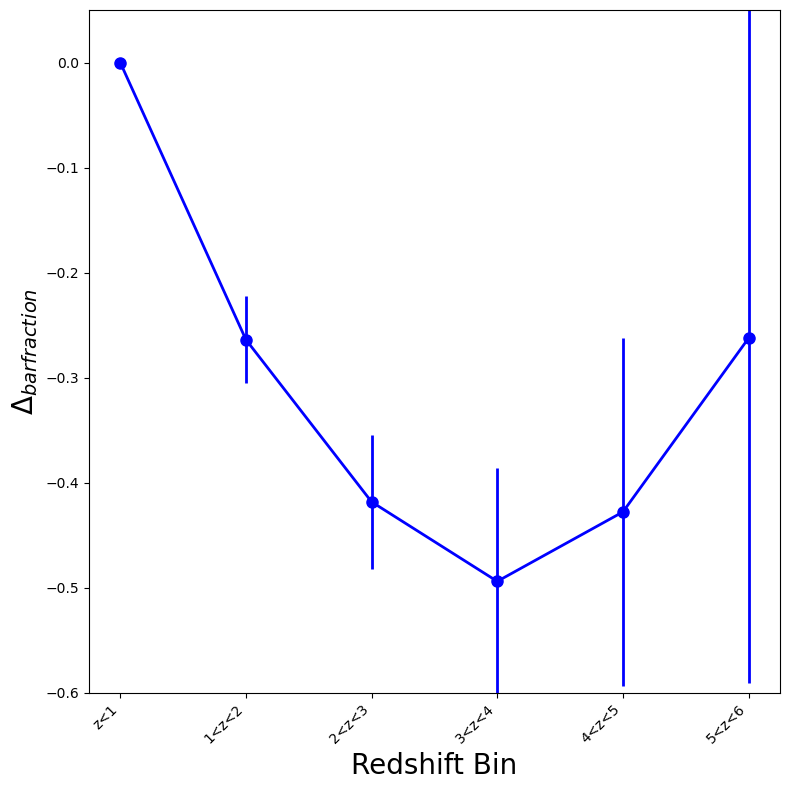

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Function to calculate mean and variance of fbar
def calculate_fbar_stats(fbar_list):
    mean_fbar = np.mean(fbar_list)
    variance_fbar = np.var(fbar_list)
    return mean_fbar, np.sqrt(variance_fbar)

# Calculate fbar stats for z<1
mean_fbar_lz, std_fbar_lz = calculate_fbar_stats(fbar_dict['z<1'])

# Calculate fbar stats for each redshift bin and compute relative change
relative_changes = []
errors = []
z_bin_labels = []

z_bin_labels.append(f'z<1')
relative_changes.append(0.0)
errors.append(0.0)

for (z_low, z_high) in [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]:
    fbar_hz = fbar_dict[f'{z_low}<z<{z_high}']
    mean_fbar_hz, std_fbar_hz = calculate_fbar_stats(fbar_hz)
    
    relative_change = (mean_fbar_hz - mean_fbar_lz) / mean_fbar_lz
    error = np.sqrt((std_fbar_hz / mean_fbar_lz) ** 2 + (mean_fbar_hz * std_fbar_lz / mean_fbar_lz ** 2) ** 2)
    
    relative_changes.append(relative_change)
    errors.append(error)
    z_bin_labels.append(f'{z_low}<z<{z_high}')

# Plot the relative changes with error bars
plt.figure(figsize=(8, 8))
plt.errorbar(z_bin_labels, relative_changes, yerr=errors, fmt='o', linestyle='-', color='blue', linewidth=2, markersize=8)
plt.xlabel('Redshift Bin', fontsize=20)
plt.ylabel('$\Delta_{bar fraction}$', fontsize=20)
#plt.title('Relative Change of fbar with Respect to z<1', fontsize=18)
plt.grid(False)
plt.ylim(-0.6, 0.05)  # Adjust y-axis limits as needed
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [67]:
print(np.mean(fbar_lz))
print(np.mean(fbar_lz)+np.sqrt(np.var(fbar_lz)))

print(np.mean(fbar_hz))
print(np.mean(fbar_hz)+np.sqrt(np.var(fbar_hz)))

0.2705145091389665
0.27940530999159097
0.15734532692815764
0.17376078633825


[708 619 109  34  16   6   1]
[170 131  26   4   0   1   0]
[0.19362187 0.17466667 0.19259259 0.10526316 0.         0.14285714
 0.        ]
[ 12  66 148  20   1   0   0]
[ 0  7 24  2  0  0  0]
[0.         0.09589041 0.13953488 0.09090909 0.         0.
 0.        ]


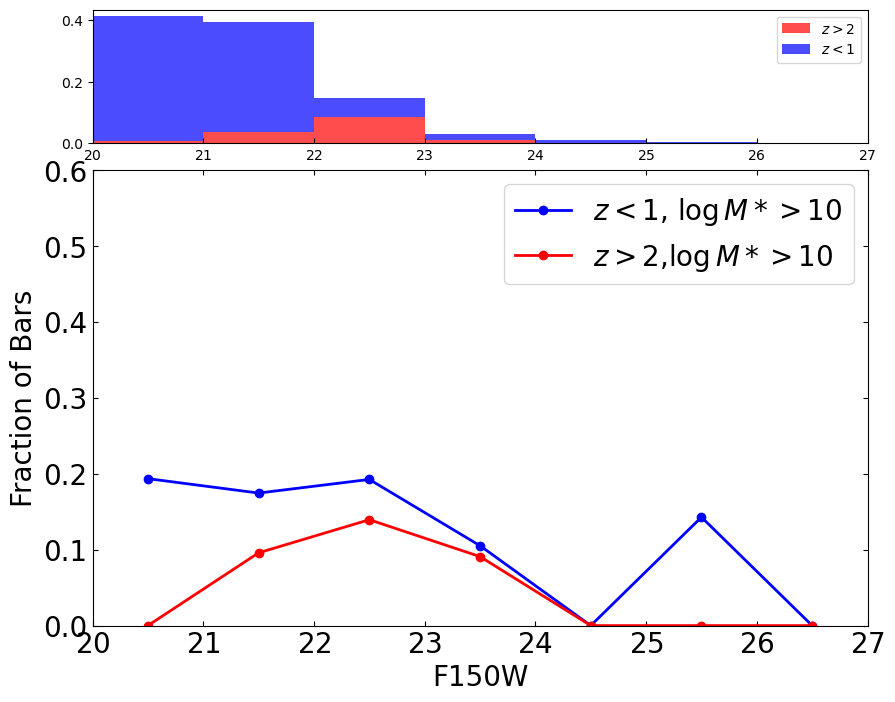

In [238]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter


bars_lz = merge.query('LP_zfinal<1.5 and LP_mass_med_PDF>10 and AXRATIO>0.5 and p_bar>0.5 and p_feature>0.5')
disks_lz = merge.query('LP_zfinal<1.5 and LP_mass_med_PDF>10  and AXRATIO>0.5 and p_feature>0.5')

m150_disks = disks_lz.RF_mag.values
m150_bars = bars_lz.RF_mag.values


bars_hz = merge.query('LP_zfinal>2 and LP_zfinal<3 and LP_mass_med_PDF>10 and LP_mass_med_PDF<11 and AXRATIO>0.5 and p_bar>0.5 and p_feature>0.5')
disks_hz = merge.query('LP_zfinal>2 and LP_zfinal<3 and LP_mass_med_PDF>10 and AXRATIO>0.5 and p_feature>0.5')

def calculate_fractions_and_plot(m150_disks, m150_bars, ax, label,color):
    # Histogram the data into these bins
    hist_disks, _ = np.histogram(m150_disks, bins=bins)
    hist_bars, _ = np.histogram(m150_bars, bins=bins)

    print(hist_disks)
    print(hist_bars)
    
    # Calculate the fraction of bars
    total = hist_disks + hist_bars
    #print(total[total>0])
    fraction_bars = np.divide(hist_bars, total)  # Avoid division by zero
    fraction_bars[total==0]=0
    print(fraction_bars)

    # Plot
    ax.plot(bin_centers, fraction_bars, marker='o', linestyle='-', linewidth=2, label=label,c=color)

# Create figure and specify grid layout
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 4, figure=fig)

# Main plot for fractions
ax_main = fig.add_subplot(gs[1:4, :])
ax_histx = fig.add_subplot(gs[0, :], sharex=ax_main)

# Plot low-z data
calculate_fractions_and_plot(disks_lz.RF_mag.values, bars_lz.RF_mag.values, ax_main, '$z<1$, $\log M*>10$',color='blue')

# Plot high-z data
calculate_fractions_and_plot(disks_hz.RF_mag.values, bars_hz.RF_mag.values, ax_main, '$z>2$,$\log M*>10$',color='red')

# Set labels and limits
ax_main.set_xlabel('F150W', fontsize=20)
ax_main.set_ylabel('Fraction of Bars', fontsize=20)
ax_main.set_xlim([20, 27])
ax_main.set_ylim([0, .6])
ax_main.legend(fontsize=20)
ax_main.tick_params(axis='both', which='both', direction='in', top=True, right=True,labelsize=20)
ax_histx.tick_params(axis='x', which='both', direction='in')

# Enable scientific notation
#ax_main.ticklabel_format( xis='y', scilimits=(0,0))
ax_main.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax_histx.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

# Plot filled histograms on top
ax_histx.hist([disks_hz.RF_mag.values,disks_lz.RF_mag.values], bins=bins, label=['$z>2$','$z<1$'], color=['red','blue'],alpha=0.7, stacked=True,density=True)
#ax_histx.hist([disks_lz.MAG_MODEL_F150W.values], bins=bins, label=['$z<1$'], color=['blue'],alpha=0.7, stacked=True,density=True)
# Adding legend to histograms
ax_histx.legend(loc='upper right')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

def calculate_fractions_and_plot(m150_disks, m150_bars, ax, label,color):
    # Histogram the data into these bins
    hist_disks, _ = np.histogram(m150_disks, bins=bins)
    hist_bars, _ = np.histogram(m150_bars, bins=bins)

    print(hist_disks)
    print(hist_bars)
    
    # Calculate the fraction of bars
    total = hist_disks + hist_bars
    #print(total[total>0])
    fraction_bars = np.divide(hist_bars, total)  # Avoid division by zero
    fraction_bars[total==0]=0
    print(fraction_bars)

    # Plot
    ax.plot(bin_centers, fraction_bars, marker='o', linestyle='-', linewidth=2, label=label,c=color)

# Create figure and specify grid layout
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 4, figure=fig)

# Main plot for fractions
ax_main = fig.add_subplot(gs[1:4, :])
ax_histx = fig.add_subplot(gs[0, :], sharex=ax_main)

# Plot low-z data
calculate_fractions_and_plot(disks_lz.RF_mag.values, bars_lz.RF_mag.values, ax_main, '$z<1$, $\log M*>10$',color='blue')

# Plot high-z data
calculate_fractions_and_plot(disks_hz.RF_mag.values, bars_hz.RF_mag.values, ax_main, '$z>2$,$\log M*>10$',color='red')

# Set labels and limits
ax_main.set_xlabel('F150W', fontsize=20)
ax_main.set_ylabel('Fraction of Bars', fontsize=20)
ax_main.set_xlim([20, 27])
ax_main.set_ylim([0, .6])
ax_main.legend(fontsize=20)
ax_main.tick_params(axis='both', which='both', direction='in', top=True, right=True,labelsize=20)
ax_histx.tick_params(axis='x', which='both', direction='in')

# Enable scientific notation
#ax_main.ticklabel_format( xis='y', scilimits=(0,0))
ax_main.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax_histx.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

# Plot filled histograms on top
ax_histx.hist([disks_hz.RF_mag.values,disks_lz.RF_mag.values], bins=bins, label=['$z>2$','$z<1$'], color=['red','blue'],alpha=0.7, stacked=True,density=True)
#ax_histx.hist([disks_lz.MAG_MODEL_F150W.values], bins=bins, label=['$z<1$'], color=['blue'],alpha=0.7, stacked=True,density=True)
# Adding legend to histograms
ax_histx.legend(loc='upper right')

plt.show()

[  4 424 805 473 203  95  47]
[  0  94 180 134  63  22  11]
[0.         0.18146718 0.18274112 0.22075783 0.23684211 0.18803419
 0.18965517]
[  1  92 111  31   3   4   2]
[ 0 11 16  4  1  0  1]
[0.         0.10679612 0.12598425 0.11428571 0.25       0.
 0.33333333]


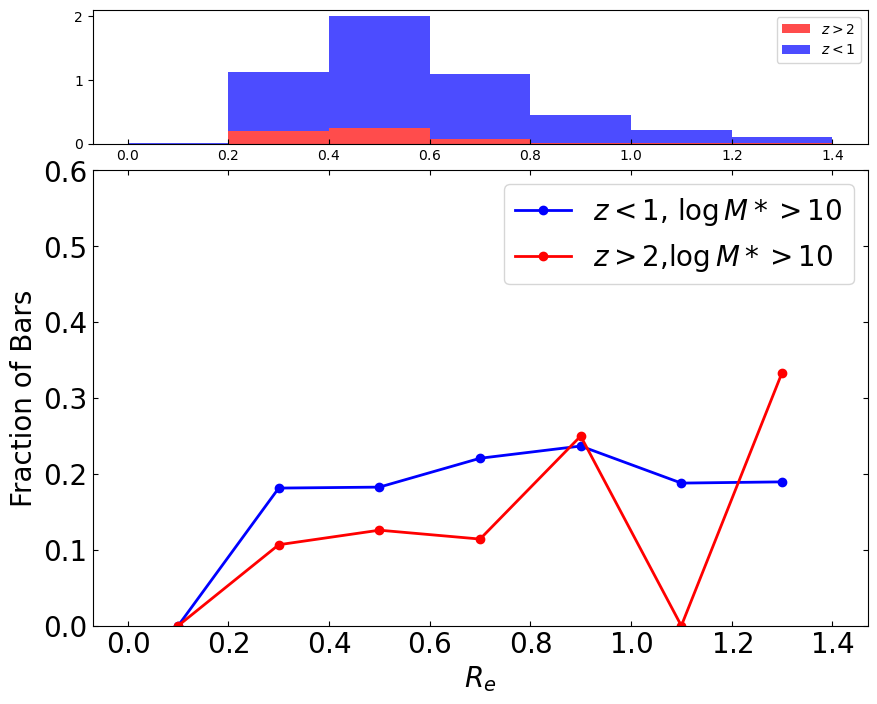

In [239]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

def calculate_fractions_and_plot(m150_disks, m150_bars, ax, label,color,bins = np.arange(0, 1.5,0.2)):
    # Histogram the data into these bins
    hist_disks, _ = np.histogram(m150_disks, bins=bins)
    hist_bars, _ = np.histogram(m150_bars, bins=bins)

    print(hist_disks)
    print(hist_bars)
    
    # Calculate the fraction of bars
    total = hist_disks + hist_bars
    #print(total[total>0])
    fraction_bars = np.divide(hist_bars, total)  # Avoid division by zero
    fraction_bars[total==0]=0
    print(fraction_bars)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot
    ax.plot(bin_centers, fraction_bars, marker='o', linestyle='-', linewidth=2, label=label,c=color)

# Create figure and specify grid layout
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 4, figure=fig)

# Main plot for fractions
ax_main = fig.add_subplot(gs[1:4, :])
ax_histx = fig.add_subplot(gs[0, :], sharex=ax_main)

# Plot low-z data
calculate_fractions_and_plot(disks_lz.RADIUS.values*3600, bars_lz.RADIUS.values*3600, ax_main, '$z<1$, $\log M*>10$',color='blue')

# Plot high-z data
calculate_fractions_and_plot(disks_hz.RADIUS.values*3600, bars_hz.RADIUS.values*3600, ax_main, '$z>2$,$\log M*>10$',color='red')

# Set labels and limits
ax_main.set_xlabel('$R_e$', fontsize=20)
ax_main.set_ylabel('Fraction of Bars', fontsize=20)
#ax_main.set_xlim([20, 27])
ax_main.set_ylim([0, .6])
ax_main.legend(fontsize=20)
ax_main.tick_params(axis='both', which='both', direction='in', top=True, right=True,labelsize=20)
ax_histx.tick_params(axis='x', which='both', direction='in')

# Enable scientific notation
#ax_main.ticklabel_format( xis='y', scilimits=(0,0))
ax_main.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax_histx.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

# Plot filled histograms on top
ax_histx.hist([disks_hz.RADIUS.values*3600,disks_lz.RADIUS.values*3600], bins=np.arange(0, 1.5,0.2), label=['$z>2$','$z<1$'], color=['red','blue'],alpha=0.7, stacked=True,density=True)
#ax_histx.hist([disks_lz.RADIUS.values], bins=bins, label=['$z<1$'], color=['blue'],alpha=0.7, stacked=True,density=True)
# Adding legend to histograms
ax_histx.legend(loc='upper right')

plt.show()


[ 259  763 1013  424  123   31   11    8]
[  0  25  94 197  62  28   8   0]


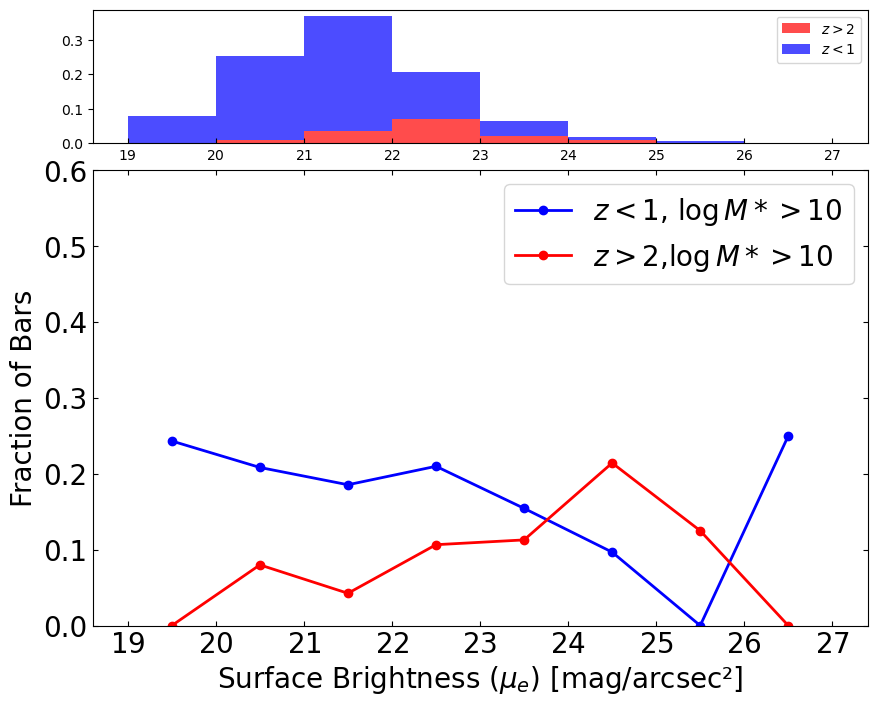

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

def calculate_surface_brightness(magnitude, radius):
    """
    Calculate the mean surface brightness within the effective radius.

    Parameters:
    magnitude (float): Total magnitude of the galaxy.
    radius (float): Effective radius in arcseconds.

    Returns:
    float: Mean surface brightness within the effective radius (mag/arcsec²).
    """
    return magnitude + 2.5 * np.log10(2 * np.pi * radius**2)

def calculate_fractions_and_plot(mag_disks, radius_disks, mag_bars, radius_bars, ax, label, color, bins):
    # Calculate surface brightness
    mu_disks = calculate_surface_brightness(mag_disks, radius_disks)
    mu_bars = calculate_surface_brightness(mag_bars, radius_bars)
    
    # Histogram the data into these bins
    hist_disks, _ = np.histogram(mu_disks, bins=bins)
    hist_bars, _ = np.histogram(mu_bars, bins=bins)
    
    # Calculate the fraction of bars
    total = hist_disks + hist_bars
    print(total)
    fraction_bars = np.divide(hist_bars, total)  # Avoid division by zero
    fraction_bars[total == 0] = 0

    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot
    ax.plot(bin_centers, fraction_bars, marker='o', linestyle='-', linewidth=2, label=label, color=color)

# Create figure and specify grid layout
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 4, figure=fig)

# Main plot for fractions
ax_main = fig.add_subplot(gs[1:4, :])
ax_histx = fig.add_subplot(gs[0, :], sharex=ax_main)

# Define bins for surface brightness
mu_bins = np.arange(19, 28, 1)

# Plot low-z data
calculate_fractions_and_plot(
    disks_lz.RF_mag.values, disks_lz.RADIUS.values * 3600,
    bars_lz.RF_mag.values, bars_lz.RADIUS.values * 3600,
    ax_main, '$z<1$, $\log M*>10$', color='blue', bins=mu_bins
)

# Plot high-z data
calculate_fractions_and_plot(
    disks_hz.RF_mag.values, disks_hz.RADIUS.values * 3600,
    bars_hz.RF_mag.values, bars_hz.RADIUS.values * 3600,
    ax_main, '$z>2$,$\log M*>10$', color='red', bins=mu_bins
)

# Set labels and limits
ax_main.set_xlabel('Surface Brightness ($\mu_e$) [mag/arcsec²]', fontsize=20)
ax_main.set_ylabel('Fraction of Bars', fontsize=20)
ax_main.set_ylim([0, .6])
ax_main.legend(fontsize=20)
ax_main.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
ax_histx.tick_params(axis='x', which='both', direction='in')

# Enable scientific notation
ax_main.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax_histx.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

# Calculate surface brightness for histograms
mu_disks_lz = calculate_surface_brightness(disks_lz.RF_mag.values, disks_lz.RADIUS.values * 3600)
mu_disks_hz = calculate_surface_brightness(disks_hz.RF_mag.values, disks_hz.RADIUS.values * 3600)

# Plot filled histograms on top
ax_histx.hist([mu_disks_hz, mu_disks_lz], bins=mu_bins, label=['$z>2$', '$z<1$'], color=['red', 'blue'], alpha=0.7, stacked=True, density=True)

# Adding legend to histograms
ax_histx.legend(loc='upper right')

plt.show()


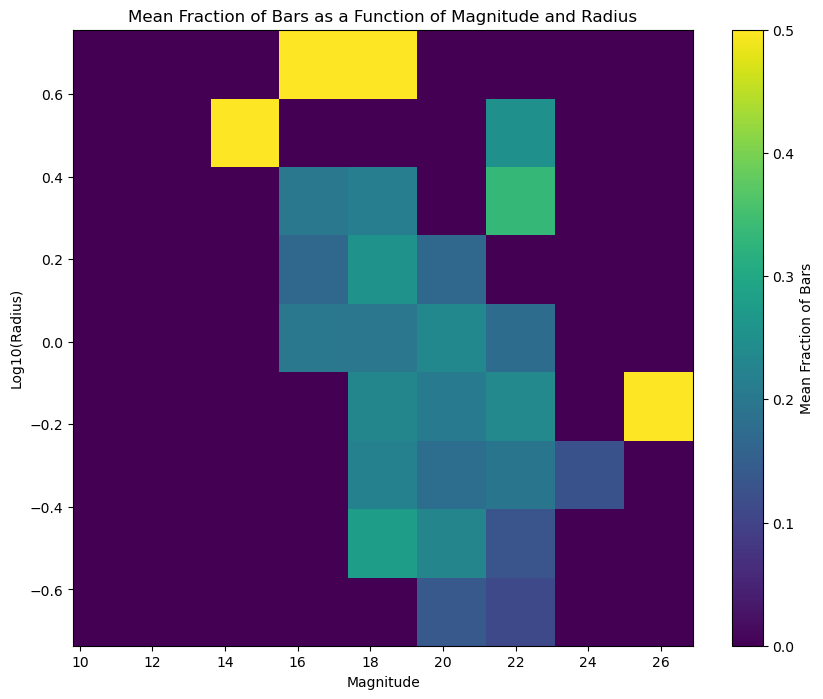

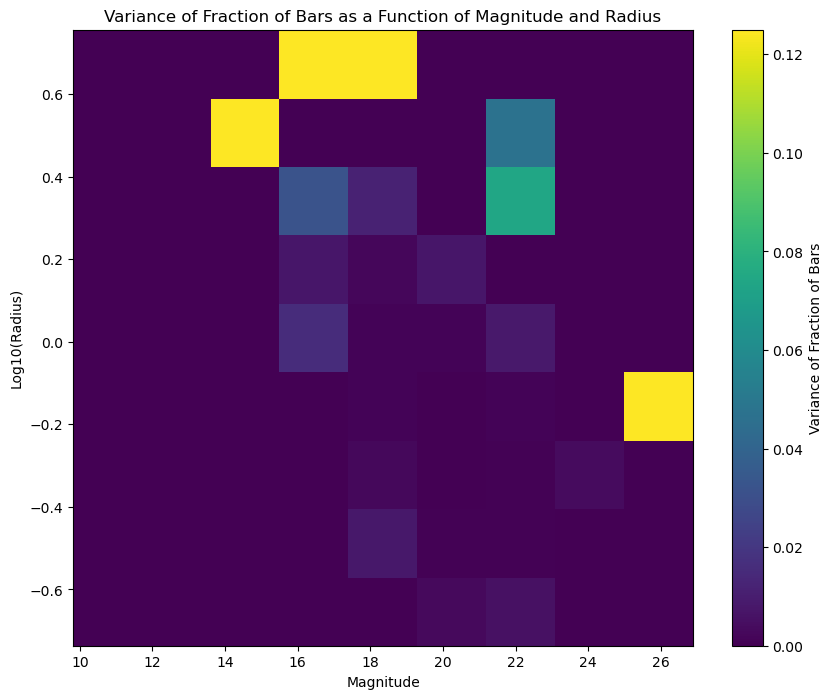

Estimated fraction of bars for magnitude 20.0 and radius 0.0004166666666666667 degrees: 0.2222222222222222


In [256]:
import numpy as np
import matplotlib.pyplot as plt

# Create the 2D histogram for bars
bars_mag = bars_lz.RF_mag.values
bars_radius = np.log10(bars_lz.RADIUS.values * 3600)
disks_mag = disks_lz.RF_mag.values
disks_radius = np.log10(disks_lz.RADIUS.values * 3600)

# Define bin edges
mag_bins = np.linspace(min(min(bars_mag), min(disks_mag)), max(max(bars_mag), max(disks_mag)), 10)
radius_bins = np.linspace(min(min(bars_radius), min(disks_radius)), max(max(bars_radius), max(disks_radius)), 10)

# Compute the 2D histograms
bars_hist, xedges, yedges = np.histogram2d(bars_mag, bars_radius, bins=[mag_bins, radius_bins])
disks_hist, _, _ = np.histogram2d(disks_mag, disks_radius, bins=[mag_bins, radius_bins])

# Calculate the total histogram
total_hist = bars_hist + disks_hist

# Calculate the mean fraction and the variance
mean_fraction_hist = np.zeros_like(bars_hist)
variance_hist = np.zeros_like(bars_hist)
nonzero_bins = total_hist > 0
mean_fraction_hist[nonzero_bins] = bars_hist[nonzero_bins] / total_hist[nonzero_bins]
variance_hist[nonzero_bins] = (mean_fraction_hist[nonzero_bins] * (1 - mean_fraction_hist[nonzero_bins])) / total_hist[nonzero_bins]

# Plot the mean fraction histogram
plt.figure(figsize=(10, 8))
plt.imshow(mean_fraction_hist.T, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
plt.colorbar(label='Mean Fraction of Bars')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Radius)')
plt.title('Mean Fraction of Bars as a Function of Magnitude and Radius')
plt.show()

# Plot the variance histogram
plt.figure(figsize=(10, 8))
plt.imshow(variance_hist.T, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
plt.colorbar(label='Variance of Fraction of Bars')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Radius)')
plt.title('Variance of Fraction of Bars as a Function of Magnitude and Radius')
plt.show()

def get_fraction_of_bars(mag, radius):
    """
    Given a magnitude and radius, return the estimated fraction of bars in that bin
    by sampling from a Poisson distribution.
    
    Parameters:
    mag (float): Magnitude value.
    radius (float): Radius value (not logarithmic).
    
    Returns:
    float: Estimated fraction of bars in the corresponding bin.
    """
    log_radius = np.log10(radius * 3600)
    
    # Find the bin indices for the given magnitude and radius
    mag_idx = np.digitize(mag, mag_bins) - 1
    radius_idx = np.digitize(log_radius, radius_bins) - 1
    
    # Ensure indices are within the valid range
    if mag_idx < 0 or mag_idx >= mean_fraction_hist.shape[0] or radius_idx < 0 or radius_idx >= mean_fraction_hist.shape[1]:
        return 0.0  # or np.nan or some other value to indicate out of range
    
    # Get the mean and variance for the fraction of bars in the bin
    mean_fraction = mean_fraction_hist[mag_idx, radius_idx]
    variance = variance_hist[mag_idx, radius_idx]
    
    # If the variance is zero, return the mean fraction
    if variance == 0:
        return mean_fraction
    
    # Sample the bar counts from a Poisson distribution
    total_count = total_hist[mag_idx, radius_idx]
    bars_count = np.random.poisson(lam=bars_hist[mag_idx, radius_idx])
    
    # Calculate the fraction of bars
    fraction_bars = bars_count / total_count if total_count > 0 else 0.0
    
    return fraction_bars

# Example usage:
mag_example = 20.0
radius_example = 1.5 / 3600  # converting arcseconds back to degrees for input
fraction = get_fraction_of_bars(mag_example, radius_example)
print(f"Estimated fraction of bars for magnitude {mag_example} and radius {radius_example} degrees: {fraction}")


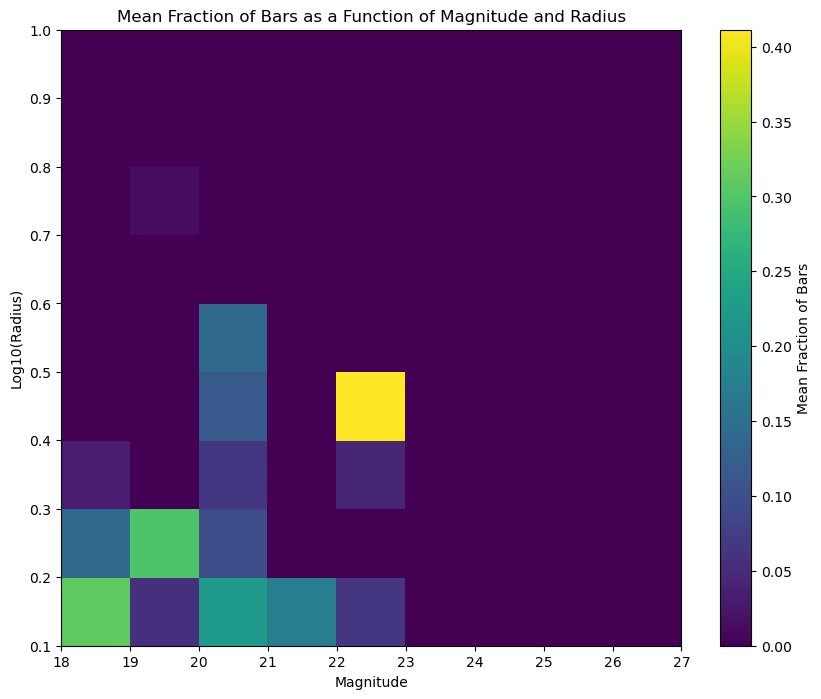

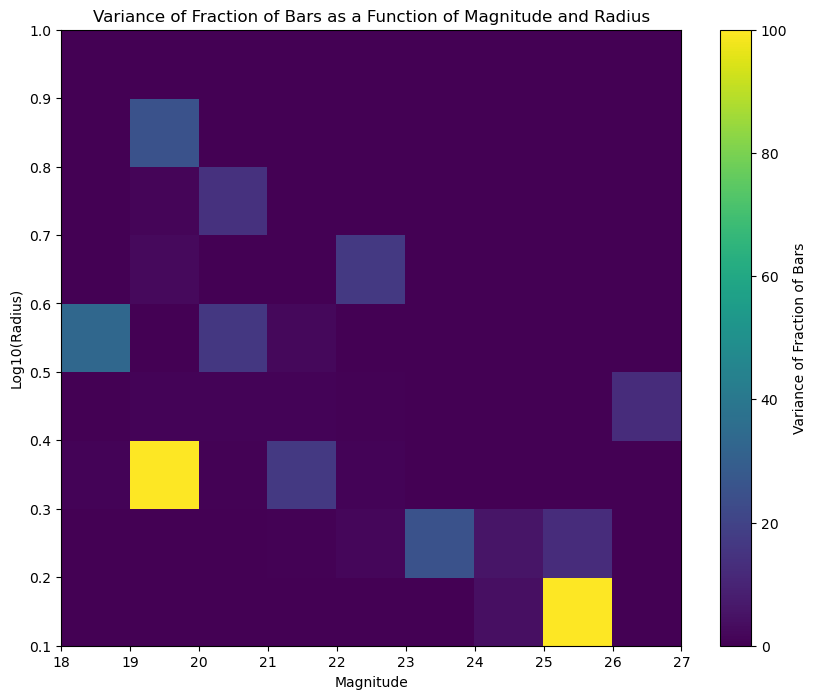

Estimated fraction of bars for magnitude 20.0 and radius 0.0004166666666666667 degrees: 0.544464609800363


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of samples and bins
N_VOLS = 100
bins = np.arange(18, 26, 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Define bin edges for 2D histograms
mag_bins = np.linspace(18, 27, 10)
radius_bins = np.linspace(0.1, 1.0, 10)

# Initialize arrays to store the histograms
histograms_bars = np.zeros((N_VOLS, len(mag_bins) - 1, len(radius_bins) - 1))
histograms_disks = np.zeros((N_VOLS, len(mag_bins) - 1, len(radius_bins) - 1))

# Calculate the histograms for each sample
for i in range(N_VOLS):
    bars_lz = merge[(merge['LP_zfinal'] < 1.5) & 
                    (merge['LP_mass_med_PDF'] > 10) & 
                    (merge['AXRATIO'] > 0.5) & 
                    (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                    (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
    
    disks_lz = merge[(merge['LP_zfinal'] < 1.5) & 
                     (merge['LP_mass_med_PDF'] > 10) & 
                     (merge['AXRATIO'] > 0.5) & 
                     (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

    bars_mag = bars_lz.RF_mag.values
    bars_radius = np.log10(bars_lz.RADIUS.values * 3600)
    disks_mag = disks_lz.RF_mag.values
    disks_radius = np.log10(disks_lz.RADIUS.values * 3600)
    
    histograms_bars[i], _, _ = np.histogram2d(bars_mag, bars_radius, bins=[mag_bins, radius_bins])
    histograms_disks[i], _, _ = np.histogram2d(disks_mag, disks_radius, bins=[mag_bins, radius_bins])

# Calculate the mean and variance of the histograms
mean_hist_bars = np.mean(histograms_bars, axis=0)
mean_hist_disks = np.mean(histograms_disks, axis=0)
var_hist_bars = np.var(histograms_bars, axis=0)
var_hist_disks = np.var(histograms_disks, axis=0)

# Calculate the total histograms and fractions
total_hist = mean_hist_bars + mean_hist_disks
mean_fraction_hist = np.zeros_like(mean_hist_bars)
variance_hist = np.zeros_like(mean_hist_bars)
poisson_errors = np.zeros_like(mean_hist_bars)

nonzero_bins = total_hist > 0
mean_fraction_hist[nonzero_bins] = mean_hist_bars[nonzero_bins] / total_hist[nonzero_bins]
poisson_errors[nonzero_bins] = np.sqrt(mean_hist_bars[nonzero_bins] + mean_hist_disks[nonzero_bins]) / total_hist[nonzero_bins]
variance_hist[nonzero_bins] = var_hist_bars[nonzero_bins] / total_hist[nonzero_bins]**2 + poisson_errors[nonzero_bins]**2

# Plot the mean fraction histogram
plt.figure(figsize=(10, 8))
plt.imshow(mean_fraction_hist.T, origin='lower', aspect='auto', extent=[mag_bins[0], mag_bins[-1], radius_bins[0], radius_bins[-1]], cmap='viridis')
plt.colorbar(label='Mean Fraction of Bars')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Radius)')
plt.title('Mean Fraction of Bars as a Function of Magnitude and Radius')
plt.show()

# Plot the variance histogram
plt.figure(figsize=(10, 8))
plt.imshow(variance_hist.T, origin='lower', aspect='auto', extent=[mag_bins[0], mag_bins[-1], radius_bins[0], radius_bins[-1]], cmap='viridis')
plt.colorbar(label='Variance of Fraction of Bars')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Radius)')
plt.title('Variance of Fraction of Bars as a Function of Magnitude and Radius')
plt.show()

def get_fraction_of_bars(mag, radius):
    """
    Given a magnitude and radius, return the estimated fraction of bars in that bin
    by sampling from a Poisson distribution.
    
    Parameters:
    mag (float): Magnitude value.
    radius (float): Radius value (not logarithmic).
    
    Returns:
    float: Estimated fraction of bars in the corresponding bin.
    """
    log_radius = np.log10(radius * 3600)
    
    # Find the bin indices for the given magnitude and radius
    mag_idx = np.digitize(mag, mag_bins) - 1
    radius_idx = np.digitize(log_radius, radius_bins) - 1
    
    # Ensure indices are within the valid range
    if mag_idx < 0 or mag_idx >= mean_fraction_hist.shape[0] or radius_idx < 0 or radius_idx >= mean_fraction_hist.shape[1]:
        return 0.0  # or np.nan or some other value to indicate out of range
    
    # Get the mean and variance for the fraction of bars in the bin
    mean_fraction = mean_fraction_hist[mag_idx, radius_idx]
    variance = variance_hist[mag_idx, radius_idx]
    
    # If the variance is zero, return the mean fraction
    if variance == 0:
        return mean_fraction
    
    # Sample the bar counts from a Poisson distribution
    total_count = total_hist[mag_idx, radius_idx]
    bars_count = np.random.poisson(lam=mean_hist_bars[mag_idx, radius_idx])
    
    # Calculate the fraction of bars
    fraction_bars = bars_count / total_count if total_count > 0 else 0.0
    
    return fraction_bars

# Example usage:
mag_example = 20.0
radius_example = 1.5 / 3600  # converting arcseconds back to degrees for input
fraction = get_fraction_of_bars(mag_example, radius_example)
print(f"Estimated fraction of bars for magnitude {mag_example} and radius {radius_example} degrees: {fraction}")


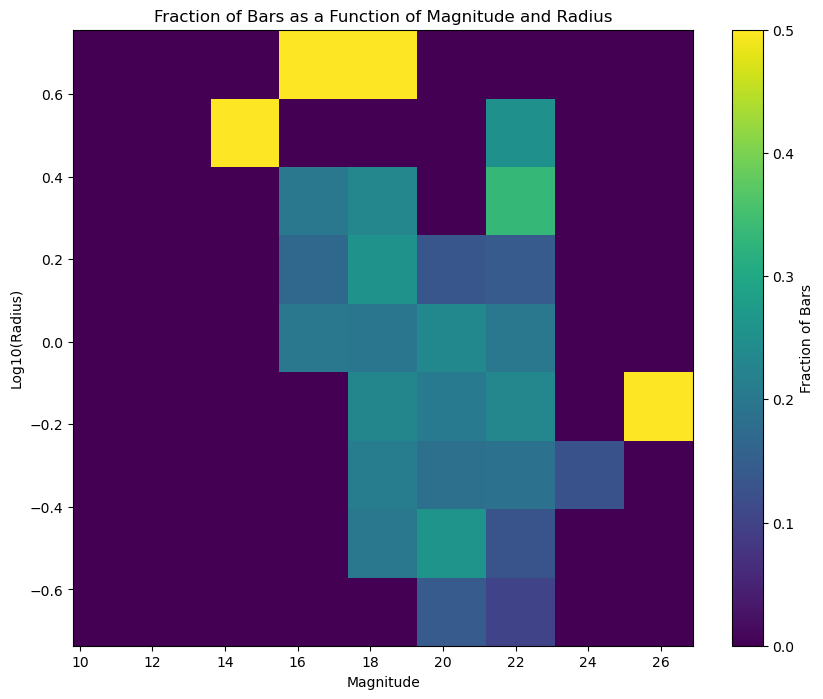

Fraction of bars for magnitude 20.0 and radius 0.0004166666666666667 degrees: 0.13333333333333333


In [211]:
import numpy as np
import matplotlib.pyplot as plt

# Create the 2D histogram for bars
bars_mag = bars_lz.RF_mag.values
bars_radius = np.log10(bars_lz.RADIUS.values * 3600)
disks_mag = disks_lz.RF_mag.values
disks_radius = np.log10(disks_lz.RADIUS.values * 3600)

# Define bin edges
mag_bins = np.linspace(min(min(bars_mag), min(disks_mag)), max(max(bars_mag), max(disks_mag)), 10)
radius_bins = np.linspace(min(min(bars_radius), min(disks_radius)), max(max(bars_radius), max(disks_radius)), 10)

# Compute the 2D histograms
bars_hist, xedges, yedges = np.histogram2d(bars_mag, bars_radius, bins=[mag_bins, radius_bins])
disks_hist, _, _ = np.histogram2d(disks_mag, disks_radius, bins=[mag_bins, radius_bins])

# Calculate the total histogram
total_hist = bars_hist + disks_hist

# Avoid division by zero
fraction_hist = np.zeros_like(bars_hist)
nonzero_bins = total_hist > 0
fraction_hist[nonzero_bins] = bars_hist[nonzero_bins] / total_hist[nonzero_bins]

# Plot the fraction histogram
plt.figure(figsize=(10, 8))
plt.imshow(fraction_hist.T, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
plt.colorbar(label='Fraction of Bars')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Radius)')
plt.title('Fraction of Bars as a Function of Magnitude and Radius')
plt.show()

def get_fraction_of_bars(mag, radius):
    """
    Given a magnitude and radius, return the fraction of bars in that bin.
    
    Parameters:
    mag (float): Magnitude value.
    radius (float): Radius value (not logarithmic).
    
    Returns:
    float: Fraction of bars in the corresponding bin.
    """
    log_radius = np.log10(radius * 3600)
    
    # Find the bin indices for the given magnitude and radius
    mag_idx = np.digitize(mag, mag_bins) - 1
    radius_idx = np.digitize(log_radius, radius_bins) - 1
    
    # Ensure indices are within the valid range
    if mag_idx < 0 or mag_idx >= fraction_hist.shape[0] or radius_idx < 0 or radius_idx >= fraction_hist.shape[1]:
        return 0.0  # or np.nan or some other value to indicate out of range
    
    return fraction_hist[mag_idx, radius_idx]

# Example usage:
mag_example = 20.0
radius_example = 1.5 / 3600  # converting arcseconds back to degrees for input
fraction = get_fraction_of_bars(mag_example, radius_example)
print(f"Fraction of bars for magnitude {mag_example} and radius {radius_example} degrees: {fraction}")


In [241]:
x = np.array([get_fraction_of_bars(mag, radius) for mag, radius in zip(disks_lz.RF_mag.values, disks_lz.RADIUS.values)])
x_hz = np.array([get_fraction_of_bars(mag, radius) for mag, radius in zip(disks_hz.RF_mag.values, disks_hz.RADIUS.values)])

In [242]:
import numpy as np
import matplotlib.pyplot as plt

# Create the 2D histogram for bars
bars_mag = bars_lz.RF_mag.values
bars_radius = np.log10(bars_lz.RADIUS.values * 3600)
disks_mag = disks_lz.RF_mag.values
disks_radius = np.log10(disks_lz.RADIUS.values * 3600)

# Define bin edges
mag_bins = np.linspace(min(min(bars_mag), min(disks_mag)), max(max(bars_mag), max(disks_mag)), 10)
radius_bins = np.linspace(min(min(bars_radius), min(disks_radius)), max(max(bars_radius), max(disks_radius)), 10)

# Compute the 2D histograms
bars_hist, xedges, yedges = np.histogram2d(bars_mag, bars_radius, bins=[mag_bins, radius_bins])
disks_hist, _, _ = np.histogram2d(disks_mag, disks_radius, bins=[mag_bins, radius_bins])

# Calculate the total histogram
total_hist = bars_hist + disks_hist

# Calculate the mean fraction and the variance
mean_fraction_hist = np.zeros_like(bars_hist)
variance_hist = np.zeros_like(bars_hist)
nonzero_bins = total_hist > 0
mean_fraction_hist[nonzero_bins] = bars_hist[nonzero_bins] / total_hist[nonzero_bins]
variance_hist[nonzero_bins] = (mean_fraction_hist[nonzero_bins] * (1 - mean_fraction_hist[nonzero_bins])) / total_hist[nonzero_bins]

def get_fraction_of_bars(mag, radius):
    """
    Given a magnitude and radius, return the estimated fraction of bars in that bin
    by sampling from a Poisson distribution.
    
    Parameters:
    mag (float): Magnitude value.
    radius (float): Radius value (not logarithmic).
    
    Returns:
    float: Estimated fraction of bars in the corresponding bin.
    """
    log_radius = np.log10(radius * 3600)
    
    # Find the bin indices for the given magnitude and radius
    mag_idx = np.digitize(mag, mag_bins) - 1
    radius_idx = np.digitize(log_radius, radius_bins) - 1
    
    # Ensure indices are within the valid range
    if mag_idx < 0 or mag_idx >= mean_fraction_hist.shape[0] or radius_idx < 0 or radius_idx >= mean_fraction_hist.shape[1]:
        return 0.0  # or np.nan or some other value to indicate out of range
    
    # Get the mean and variance for the fraction of bars in the bin
    mean_fraction = mean_fraction_hist[mag_idx, radius_idx]
    variance = variance_hist[mag_idx, radius_idx]
    
    # If the variance is zero, return the mean fraction
    if variance == 0:
        return mean_fraction
    
    # Sample the bar counts from a Poisson distribution
    total_count = total_hist[mag_idx, radius_idx]
    bars_count = np.random.poisson(lam=bars_hist[mag_idx, radius_idx])
    
    # Calculate the fraction of bars
    fraction_bars = bars_count / total_count if total_count > 0 else 0.0
    
    return fraction_bars

# Compute x_hz
x_hz = np.array([get_fraction_of_bars(mag, radius) for mag, radius in zip(disks_hz.RF_mag.values, disks_hz.RADIUS.values)])

# Digitize the data to get the bin indices
mag_indices = np.digitize(disks_hz.RF_mag.values, mag_bins) - 1
radius_indices = np.digitize(np.log10(disks_hz.RADIUS.values * 3600), radius_bins) - 1

# Compute the weights for each entry in x_hz
weights = np.array([total_hist[mag_idx, radius_idx] for mag_idx, radius_idx in zip(mag_indices, radius_indices)])

# Filter out invalid indices (i.e., where the total count is zero)
valid_mask = (mag_indices >= 0) & (mag_indices < len(mag_bins) - 1) & \
             (radius_indices >= 0) & (radius_indices < len(radius_bins) - 1) & \
             (weights > 0)

x_hz_valid = x_hz[valid_mask]
weights_valid = weights[valid_mask]

# Compute the weighted mean
weighted_mean_x_hz = np.average(x_hz_valid, weights=weights_valid)

print(f"Weighted mean of x_hz: {weighted_mean_x_hz}")


Weighted mean of x_hz: 0.18224433348899027


In [260]:
import numpy as np
import matplotlib.pyplot as plt

# Create the 2D histogram for bars
bars_mag = bars_lz.RF_mag.values
bars_radius = np.log10(bars_lz.RADIUS.values * 3600)
disks_mag = disks_lz.RF_mag.values
disks_radius = np.log10(disks_lz.RADIUS.values * 3600)

# Define bin edges
mag_bins = np.linspace(min(min(bars_mag), min(disks_mag)), max(max(bars_mag), max(disks_mag)), 10)
radius_bins = np.linspace(min(min(bars_radius), min(disks_radius)), max(max(bars_radius), max(disks_radius)), 10)

# Compute the 2D histograms
bars_hist, xedges, yedges = np.histogram2d(bars_mag, bars_radius, bins=[mag_bins, radius_bins])
disks_hist, _, _ = np.histogram2d(disks_mag, disks_radius, bins=[mag_bins, radius_bins])

# Calculate the total histogram
total_hist = bars_hist + disks_hist

# Calculate the mean fraction and the variance
mean_fraction_hist = np.zeros_like(bars_hist)
variance_hist = np.zeros_like(bars_hist)
nonzero_bins = total_hist > 0
mean_fraction_hist[nonzero_bins] = bars_hist[nonzero_bins] / total_hist[nonzero_bins]
variance_hist[nonzero_bins] = mean_fraction_hist[nonzero_bins] * (1 - mean_fraction_hist[nonzero_bins]) / total_hist[nonzero_bins]

# Compute the number of objects in each bin of disks_hz
disks_hz_mag = disks_hz.RF_mag.values
disks_hz_radius = np.log10(disks_hz.RADIUS.values * 3600)
disks_hz_hist, _, _ = np.histogram2d(disks_hz_mag, disks_hz_radius, bins=[mag_bins, radius_bins])

def get_fraction_of_bars(mag, radius):
    """
    Given a magnitude and radius, return the estimated fraction of bars in that bin
    by sampling from a Poisson distribution.
    
    Parameters:
    mag (float): Magnitude value.
    radius (float): Radius value (not logarithmic).
    
    Returns:
    float: Estimated fraction of bars in the corresponding bin.
    """
    log_radius = np.log10(radius * 3600)
    
    # Find the bin indices for the given magnitude and radius
    mag_idx = np.digitize(mag, mag_bins) - 1
    radius_idx = np.digitize(log_radius, radius_bins) - 1
    
    # Ensure indices are within the valid range
    if mag_idx < 0 or mag_idx >= mean_fraction_hist.shape[0] or radius_idx < 0 or radius_idx >= mean_fraction_hist.shape[1]:
        return 0.0  # or np.nan or some other value to indicate out of range
    
    # Get the mean fraction and the number of objects in the bin
    mean_fraction = mean_fraction_hist[mag_idx, radius_idx]
    num_objects_in_bin = disks_hz_hist[mag_idx, radius_idx]
    
    # If the number of objects is zero, return zero
    if num_objects_in_bin == 0:
        return 0.0
    
    # Sample the bar counts from a Poisson distribution using the number of objects in the bin
    bars_count = np.random.poisson(lam=mean_fraction * num_objects_in_bin)
    
    # Calculate the fraction of bars
    fraction_bars = bars_count / num_objects_in_bin
    
    return fraction_bars

# Generate 100 samples of the number of expected bars
num_samples = 100
num_bars_samples = np.zeros(num_samples)

for i in range(num_samples):
    num_bars = 0
    for mag, radius in zip(disks_hz.RF_mag.values, disks_hz.RADIUS.values):
        num_bars += get_fraction_of_bars(mag, radius)
    num_bars_samples[i] = num_bars

# Calculate the total number of objects in disks_hz
total_objects = len(disks_hz)

# Calculate the bar fraction for each sample
bar_fractions = num_bars_samples / total_objects

# Compute the mean and variance of the bar fraction
mean_bar_fraction = np.mean(bar_fractions)
variance_bar_fraction = np.var(bar_fractions)

print(f"Mean bar fraction: {mean_bar_fraction}")
print(f"Variance of bar fraction: {variance_bar_fraction}")


Mean bar fraction: 0.17523780746576814
Variance of bar fraction: 4.055078230682422e-05


Mean bar fraction: 0.18027843189122814
Sigma of bar fraction: 0.03510912017838776


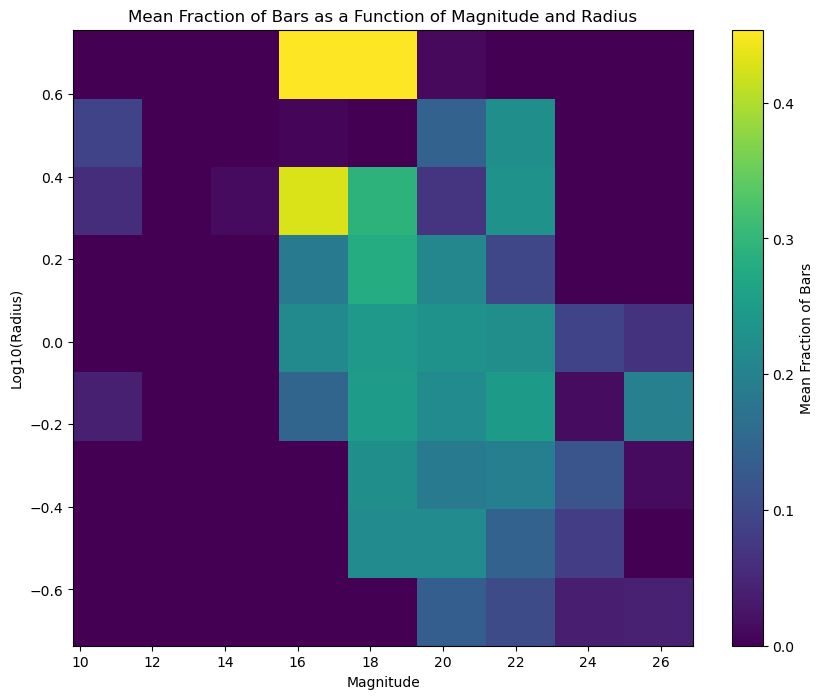

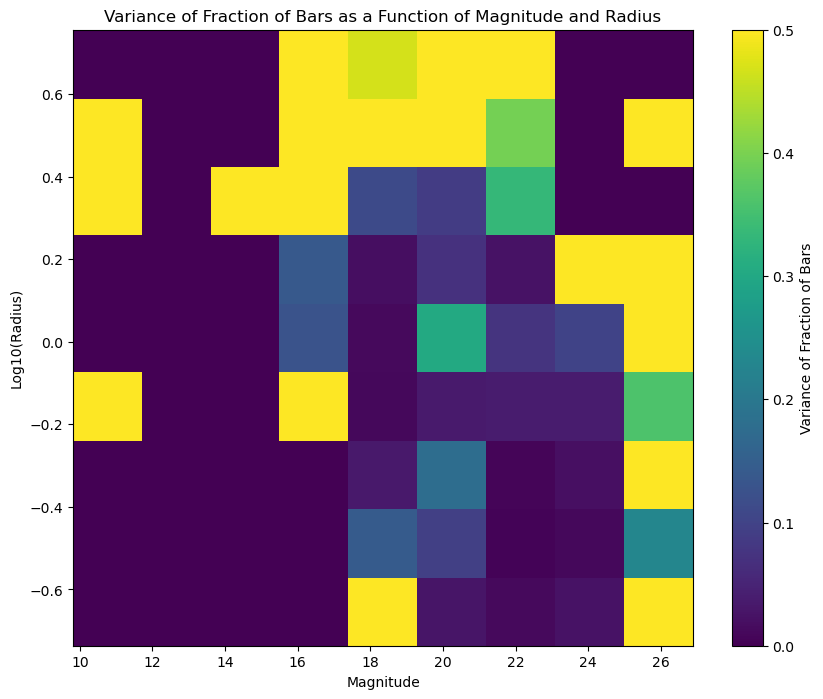

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure the p_bar_samples and p_feature_samples columns are lists/arrays
merge['p_bar_samples'] = merge['p_bar_samples'].apply(lambda x: np.array(x))
merge['p_feature_samples'] = merge['p_feature_samples'].apply(lambda x: np.array(x))

# Calculate the mean of the samples
merge['p_bar_mean'] = merge['p_bar_samples'].apply(np.mean)
merge['p_feature_mean'] = merge['p_feature_samples'].apply(np.mean)

# Select bars and disks for low-z and high-z using the mean values
bars_lz = merge.query('LP_zfinal < 1.5 and LP_mass_med_PDF > 10 and LP_mass_med_PDF < 11 and AXRATIO > 0.5 and p_bar_mean > 0.5 and p_feature_mean > 0.5')
disks_lz = merge.query('LP_zfinal < 1.5 and LP_mass_med_PDF > 10 and LP_mass_med_PDF < 11 and AXRATIO > 0.5 and p_feature_mean > 0.5')

bars_hz = merge.query('LP_zfinal > 3 and LP_zfinal < 6 and LP_mass_med_PDF > 10 and LP_mass_med_PDF < 11 and AXRATIO > 0.5 and p_bar_mean > 0.5 and p_feature_mean > 0.5')
disks_hz = merge.query('LP_zfinal > 3 and LP_zfinal < 6 and LP_mass_med_PDF > 10 and LP_mass_med_PDF < 11 and AXRATIO > 0.5 and p_feature_mean > 0.5')

# Get magnitude and radius values for the histograms
bars_mag = bars_lz.RF_mag.values
bars_radius = np.log10(bars_lz.RADIUS.values * 3600)
disks_mag = disks_lz.RF_mag.values
disks_radius = np.log10(disks_lz.RADIUS.values * 3600)

# Define bin edges
mag_bins = np.linspace(min(min(bars_mag), min(disks_mag)), max(max(bars_mag), max(disks_mag)), 10)
radius_bins = np.linspace(min(min(bars_radius), min(disks_radius)), max(max(bars_radius), max(disks_radius)), 10)

# Initialize arrays to store the histograms for each sample
histograms_bars = np.zeros((100, len(mag_bins) - 1, len(radius_bins) - 1))
histograms_disks = np.zeros((100, len(mag_bins) - 1, len(radius_bins) - 1))
histograms_fbar = np.zeros((100, len(mag_bins) - 1, len(radius_bins) - 1))

# Calculate the histograms for each sample
for i in range(100):
    bars_lz_sample = merge[(merge['LP_zfinal'] < 1) & 
                           (merge['LP_mass_med_PDF'] > 10) & 
                           (merge['LP_mass_med_PDF'] < 11) & 
                           (merge['AXRATIO'] > 0.5) & 
                           (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                           (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
    
    disks_lz_sample = merge[(merge['LP_zfinal'] < 1) & 
                            (merge['LP_mass_med_PDF'] > 10) & 
                            (merge['LP_mass_med_PDF'] < 11) & 
                            (merge['AXRATIO'] > 0.5) & 
                            (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

    bars_hz_sample = merge[(merge['LP_zfinal'] > 3) & 
                           (merge['LP_zfinal'] < 6) & 
                           (merge['LP_mass_med_PDF'] > 10) & 
                           (merge['LP_mass_med_PDF'] < 11) & 
                           (merge['AXRATIO'] > 0.5) & 
                           (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                           (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
    
    disks_hz_sample = merge[(merge['LP_zfinal'] > 3) & 
                            (merge['LP_zfinal'] < 6) & 
                            (merge['LP_mass_med_PDF'] > 10) &
                            (merge['LP_mass_med_PDF'] < 11) & 
                            (merge['AXRATIO'] > 0.5) & 
                            (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

    bars_mag_sample = bars_lz_sample.RF_mag.values
    bars_radius_sample = np.log10(bars_lz_sample.RADIUS.values * 3600)
    disks_mag_sample = disks_lz_sample.RF_mag.values
    disks_radius_sample = np.log10(disks_lz_sample.RADIUS.values * 3600)
    
    histograms_bars[i], _, _ = np.histogram2d(bars_mag_sample, bars_radius_sample, bins=[mag_bins, radius_bins])
    histograms_disks[i], _, _ = np.histogram2d(disks_mag_sample, disks_radius_sample, bins=[mag_bins, radius_bins])
    nonzero_bins = histograms_disks[i] > 0
    (histograms_fbar[i])[nonzero_bins] = (histograms_bars[i])[nonzero_bins]/(histograms_disks[i])[nonzero_bins]

# Calculate the mean and variance of the histograms over the samples
mean_hist_bars = np.mean(histograms_fbar, axis=0)
var_hist_bars = np.var(histograms_fbar, axis=0)

# Compute the number of objects in each bin of disks_hz
disks_hz_mag = disks_hz.RF_mag.values
disks_hz_radius = np.log10(disks_hz.RADIUS.values * 3600)
disks_hz_hist, _, _ = np.histogram2d(disks_hz_mag, disks_hz_radius, bins=[mag_bins, radius_bins])

nonzero_bins = disks_hz_hist > 0
p  = mean_hist_bars[nonzero_bins]*disks_hz_hist[nonzero_bins]
#poisson_errors[nonzero_bins] = np.sqrt(p*(1-p)/disks_hz_hist[nonzero_bins])
poisson_errors[nonzero_bins] = np.sqrt(mean_hist_bars[nonzero_bins] * (1 - mean_hist_bars[nonzero_bins]) / disks_hz_hist[nonzero_bins])
variance_hist[nonzero_bins] = var_hist_bars[nonzero_bins] + poisson_errors[nonzero_bins]**2


# Generate 100 samples of the number of expected bars
num_samples = 100
num_bars_samples = np.zeros(num_samples)


for i in range(num_samples):
    
   frac_bars = np.random.normal(loc=mean_hist_bars, scale=np.sqrt(variance_hist))
   num_bars_samples[i] = np.sum(frac_bars*disks_hz_hist)
   
# Calculate the total number of objects in disks_hz
total_objects = np.sum(disks_hz_hist)

# Calculate the bar fraction for each sample
bar_fractions = num_bars_samples / total_objects

# Compute the mean and variance of the bar fraction
mean_bar_fraction = np.mean(bar_fractions)
variance_bar_fraction = np.sqrt(np.var(bar_fractions))

print(f"Mean bar fraction: {mean_bar_fraction}")
print(f"Sigma of bar fraction: {variance_bar_fraction}")

# Plot the mean fraction histogram
plt.figure(figsize=(10, 8))
plt.imshow(mean_fraction_hist.T, origin='lower', aspect='auto', extent=[mag_bins[0], mag_bins[-1], radius_bins[0], radius_bins[-1]], cmap='viridis')
plt.colorbar(label='Mean Fraction of Bars')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Radius)')
plt.title('Mean Fraction of Bars as a Function of Magnitude and Radius')
plt.show()

# Plot the variance histogram
plt.figure(figsize=(10, 8))
plt.imshow(variance_hist.T, origin='lower', aspect='auto', extent=[mag_bins[0], mag_bins[-1], radius_bins[0], radius_bins[-1]], cmap='viridis',vmin=0,vmax=0.5)
plt.colorbar(label='Variance of Fraction of Bars')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Radius)')
plt.title('Variance of Fraction of Bars as a Function of Magnitude and Radius')
plt.show()


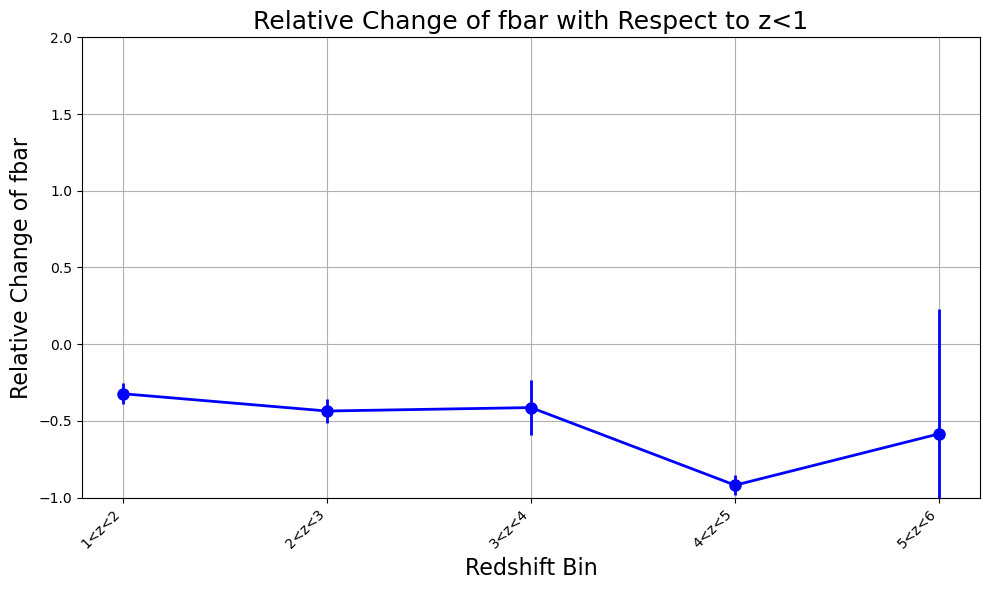

1<z<2: Mean fbar = 0.18948113268408096, Std. Dev. = 0.015655331203574662
2<z<3: Mean fbar = 0.15793387869346012, Std. Dev. = 0.019705341677225253
3<z<4: Mean fbar = 0.1641856938769867, Std. Dev. = 0.0495447395807727
4<z<5: Mean fbar = 0.022683413220476175, Std. Dev. = 0.018510164462661207
5<z<6: Mean fbar = 0.11635361308965511, Std. Dev. = 0.22838553896834757
z<1: Mean fbar = 0.27979488601455893, Std. Dev. = 0.015921828543769913


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Ensure the p_bar_samples and p_feature_samples columns are lists/arrays
merge['p_bar_samples'] = merge['p_bar_samples'].apply(lambda x: np.array(x))
merge['p_feature_samples'] = merge['p_feature_samples'].apply(lambda x: np.array(x))

# Calculate the mean of the samples
merge['p_bar_mean'] = merge['p_bar_samples'].apply(np.mean)
merge['p_feature_mean'] = merge['p_feature_samples'].apply(np.mean)

# Select bars and disks for low-z using the mean values
bars_lz = merge.query('LP_zfinal < 1 and LP_mass_med_PDF > 10 and LP_mass_med_PDF < 11 and AXRATIO > 0.5 and p_bar_mean > 0.5 and p_feature_mean > 0.5')
disks_lz = merge.query('LP_zfinal < 1 and LP_mass_med_PDF > 10 and LP_mass_med_PDF < 11 and AXRATIO > 0.5 and p_feature_mean > 0.5')

# Get magnitude and radius values for the histograms
bars_mag = bars_lz.RF_mag.values
bars_radius = np.log10(bars_lz.RADIUS.values * 3600)
disks_mag = disks_lz.RF_mag.values
disks_radius = np.log10(disks_lz.RADIUS.values * 3600)

# Define bin edges
mag_bins = np.linspace(min(min(bars_mag), min(disks_mag)), max(max(bars_mag), max(disks_mag)), 5)
radius_bins = np.linspace(min(min(bars_radius), min(disks_radius)), max(max(bars_radius), max(disks_radius)),5)

# Function to calculate histograms and fractions
def calculate_histograms_and_fractions(merge, z_low, z_high):
    histograms_bars = np.zeros((100, len(mag_bins) - 1, len(radius_bins) - 1))
    histograms_disks = np.zeros((100, len(mag_bins) - 1, len(radius_bins) - 1))
    histograms_fbar = np.zeros((100, len(mag_bins) - 1, len(radius_bins) - 1))
    
    for i in range(100):
        bars_hz_sample = merge[(merge['LP_zfinal'] > z_low) & 
                               (merge['LP_zfinal'] < z_high) & 
                               (merge['LP_mass_med_PDF'] > 10) & 
                               (merge['LP_mass_med_PDF'] < 11) & 
                               (merge['AXRATIO'] > 0.5) & 
                               (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                               (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        disks_hz_sample = merge[(merge['LP_zfinal'] > z_low) & 
                                (merge['LP_zfinal'] < z_high) & 
                                (merge['LP_mass_med_PDF'] > 10) &
                                (merge['LP_mass_med_PDF'] < 11) & 
                                (merge['AXRATIO'] > 0.5) & 
                                (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        bars_mag_sample = bars_hz_sample.RF_mag.values
        bars_radius_sample = np.log10(bars_hz_sample.RADIUS.values * 3600)
        disks_mag_sample = disks_hz_sample.RF_mag.values
        disks_radius_sample = np.log10(disks_hz_sample.RADIUS.values * 3600)
        
        histograms_bars[i], _, _ = np.histogram2d(bars_mag_sample, bars_radius_sample, bins=[mag_bins, radius_bins])
        histograms_disks[i], _, _ = np.histogram2d(disks_mag_sample, disks_radius_sample, bins=[mag_bins, radius_bins])
        nonzero_bins = histograms_disks[i] > 0
        histograms_fbar[i][nonzero_bins] = histograms_bars[i][nonzero_bins] / histograms_disks[i][nonzero_bins]
    
    # Calculate the mean and variance of the histograms over the samples
    mean_hist_bars = np.mean(histograms_fbar, axis=0)
    var_hist_bars = np.var(histograms_fbar, axis=0)
    
    # Compute the number of objects in each bin of disks_hz
    disks_hz_hist, _, _ = np.histogram2d(disks_mag, disks_radius, bins=[mag_bins, radius_bins])
    
    nonzero_bins = disks_hz_hist > 0
    p = mean_hist_bars[nonzero_bins] * disks_hz_hist[nonzero_bins]
    poisson_errors = np.sqrt(mean_hist_bars[nonzero_bins] * (1 - mean_hist_bars[nonzero_bins]) / disks_hz_hist[nonzero_bins])
    variance_hist = np.zeros_like(var_hist_bars)
    variance_hist[nonzero_bins] = var_hist_bars[nonzero_bins] + poisson_errors**2
    
    # Generate 100 samples of the number of expected bars
    num_samples = 100
    num_bars_samples = np.zeros(num_samples)
    
    for i in range(num_samples):
        frac_bars = np.random.normal(loc=mean_hist_bars, scale=np.sqrt(variance_hist))
        num_bars_samples[i] = np.sum(frac_bars * disks_hz_hist)
    
    # Calculate the total number of objects in disks_hz
    total_objects = np.sum(disks_hz_hist)
    
    # Calculate the bar fraction for each sample
    bar_fractions = num_bars_samples / total_objects
    
    # Compute the mean and variance of the bar fraction
    mean_bar_fraction = np.mean(bar_fractions)
    variance_bar_fraction = np.sqrt(np.var(bar_fractions))
    
    return mean_bar_fraction, variance_bar_fraction

# Redshift bins for high-z
z_bins = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
fbar_stats_dict = {}

# Calculate mean_bar_fraction and variance for each redshift bin
for z_low, z_high in z_bins:
    mean_bar_fraction, variance_bar_fraction = calculate_histograms_and_fractions(merge, z_low, z_high)
    fbar_stats_dict[f'{z_low}<z<{z_high}'] = (mean_bar_fraction, variance_bar_fraction)

# Calculate mean_bar_fraction and variance for low-z (z<1)
mean_bar_fraction_lz, variance_bar_fraction_lz = calculate_histograms_and_fractions(merge, 0, 1)
fbar_stats_dict['z<1'] = (mean_bar_fraction_lz, variance_bar_fraction_lz)

# Calculate the relative change of fbar as referred to the point at z<1
relative_changes = []
errors = []
z_bin_labels = []

for z_low, z_high in z_bins:
    mean_fbar_hz, std_fbar_hz = fbar_stats_dict[f'{z_low}<z<{z_high}']
    
    relative_change = (mean_fbar_hz - mean_bar_fraction_lz) / mean_bar_fraction_lz
    error = np.sqrt((std_fbar_hz / mean_bar_fraction_lz) ** 2 + (mean_fbar_hz * variance_bar_fraction_lz / mean_bar_fraction_lz ** 2) ** 2)
    
    relative_changes.append(relative_change)
    errors.append(error)
    z_bin_labels.append(f'{z_low}<z<{z_high}')

# Plot the relative changes with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(z_bin_labels, relative_changes, yerr=errors, fmt='o', linestyle='-', color='blue', linewidth=2, markersize=8)
plt.xlabel('Redshift Bin', fontsize=16)
plt.ylabel('Relative Change of fbar', fontsize=16)
plt.title('Relative Change of fbar with Respect to z<1', fontsize=18)
plt.grid(True)
plt.ylim(-1, 2)  # Adjust y-axis limits as needed
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the fbar statistics dictionary
for key, value in fbar_stats_dict.items():
    print(f"{key}: Mean fbar = {value[0]}, Std. Dev. = {value[1]}")


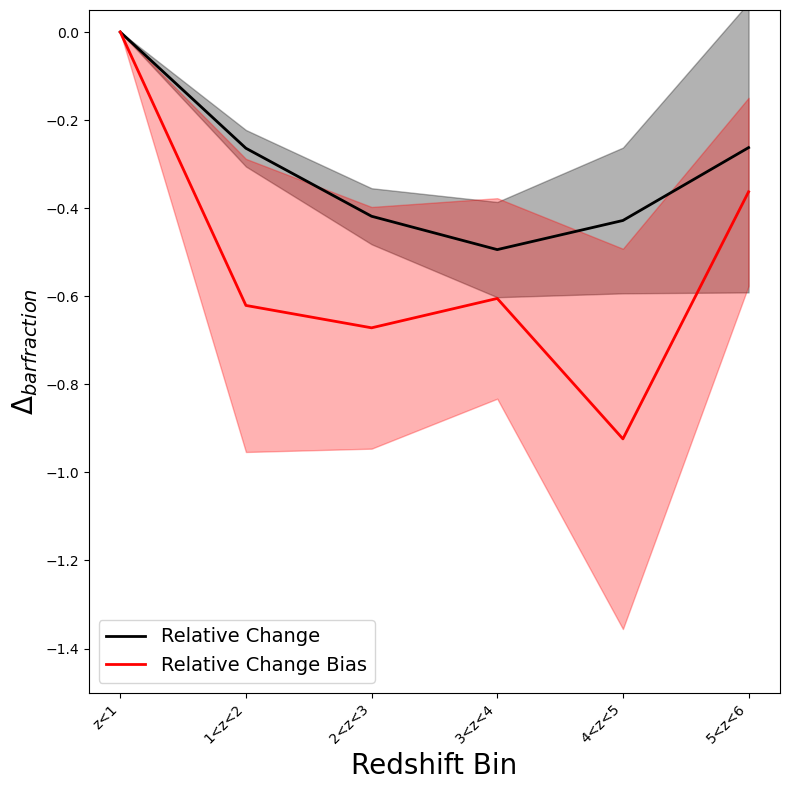

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Function to calculate mean and variance of fbar
def calculate_fbar_stats(fbar_list):
    mean_fbar = np.mean(fbar_list)
    variance_fbar = np.var(fbar_list)
    return mean_fbar, np.sqrt(variance_fbar)

# Calculate fbar stats for z<1
mean_fbar_lz, std_fbar_lz = calculate_fbar_stats(fbar_dict['z<1'])

# Calculate fbar stats for each redshift bin and compute relative change
relative_changes = []
errors = []
relative_changes_bias = []
errors_bias = []
z_bin_labels = []

z_bin_labels.append(f'z<1')
relative_changes.append(0.0)
errors.append(0.0)

relative_changes_bias.append(0.0)
errors_bias.append(0.0)

for (z_low, z_high) in [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]:
    fbar_hz = fbar_dict[f'{z_low}<z<{z_high}']
    fbar_bias = fbar_stats_dict[f'{z_low}<z<{z_high}']
    mean_fbar_hz, std_fbar_hz = calculate_fbar_stats(fbar_hz)
    mean_fbar_bias, std_fbar_bias = calculate_fbar_stats(fbar_bias)
    
    relative_change = (mean_fbar_hz - mean_fbar_lz) / mean_fbar_lz
    error = np.sqrt((std_fbar_hz / mean_fbar_lz) ** 2 + (mean_fbar_hz * std_fbar_lz / mean_fbar_lz ** 2) ** 2)

    relative_change_bias = (mean_fbar_bias - mean_fbar_lz) / mean_fbar_lz
    error_bias = np.sqrt((std_fbar_bias / mean_fbar_lz) ** 2 + (mean_fbar_bias * std_fbar_lz / mean_fbar_bias ** 2) ** 2)
    
    relative_changes.append(relative_change)
    errors.append(error)

    relative_changes_bias.append(relative_change_bias)
    errors_bias.append(error_bias)
    z_bin_labels.append(f'{z_low}<z<{z_high}')

# Plot the relative changes with shaded regions
plt.figure(figsize=(8, 8))
plt.plot(z_bin_labels, relative_changes, color='black', linewidth=2, markersize=8, label='Relative Change')
plt.fill_between(z_bin_labels, np.array(relative_changes) - np.array(errors), np.array(relative_changes) + np.array(errors), color='black', alpha=0.3)

plt.plot(z_bin_labels, relative_changes_bias, color='red', linewidth=2, markersize=8, label='Relative Change Bias')
plt.fill_between(z_bin_labels, np.array(relative_changes_bias) - np.array(errors_bias), np.array(relative_changes_bias) + np.array(errors_bias), color='red', alpha=0.3)

plt.xlabel('Redshift Bin', fontsize=20)
plt.ylabel('$\Delta_{bar fraction}$', fontsize=20)
plt.grid(False)
plt.ylim(-1.5, 0.05)  # Adjust y-axis limits as needed
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower left', fontsize=14)
plt.tight_layout()
plt.show()


In [50]:
print(len(bars_hz_sample)/len(disks_hz_sample))

0.1593625498007968


In [42]:
0.2198062046+ np.sqrt(0.0006789459252112279)

0.2458627954209656

In [31]:
print(np.sqrt(np.var(bar_fractions)))

0.006282318166642772


In [24]:
merge['p_bar_samples'] = merge['p_bar_samples'].apply(lambda x: np.array(x))

In [26]:
print(len(bars_lz)/len(disks_lz))
print(len(bars_hz)/len(disks_hz))

0.2448501872659176
0.13654618473895583


In [27]:
def calculate_fractions_and_plot(m150_disks, m150_bars, bins):
    # Histogram the data into these bins
    hist_disks, _ = np.histogram(m150_disks, bins=bins)
    hist_bars, _ = np.histogram(m150_bars, bins=bins)

    print(hist_disks)
    print(hist_bars)
    
    # Calculate the fraction of bars
    total = hist_disks + hist_bars
    #print(total[total>0])
    fraction_bars = np.divide(hist_bars, total)  # Avoid division by zero
    fraction_bars[total==0]=0
    print(fraction_bars)

    # Plot
    bin_centers = (bins[:-1] + bins[1:]) / 2
    return bin_centers,fraction_bars
    ax.plot(bin_centers, fraction_bars, marker='o', linestyle='-', linewidth=2, label=label,c=color)







# Bin centers for plotting

# Define bins for MAG_MODEL_F150W
#mag_bins = np.linspace(min(disks_hz.MAG_MODEL_F150W.values), max(disks_hz.MAG_MODEL_F150W.values), 10)
mag_bins = np.arange(20, 28, 1)
# Digitize the magnitudes to get bin indices
bin_indices = np.digitize(disks_hz.MAG_MODEL_F150W.values, bins=mag_bins)

# Calculate the mean of x_hz in each bin
mean_x_hz = []
bin_centers = []

for i in range(1, len(mag_bins)):
    bin_mask = bin_indices == i
    if np.any(bin_mask):
        mean_x_hz.append(np.mean(x_hz[bin_mask]))
        bin_centers.append((mag_bins[i-1] + mag_bins[i]) / 2)

# Plot low-z data
#calculate_fractions_and_plot(disks_lz.MAG_MODEL_F150W.values, bars_lz.MAG_MODEL_F150W.values, ax_main, '$z<1$, $\log M*>10$',color='blue')

# Plot high-z data
bins_c, fbar = calculate_fractions_and_plot(disks_hz.MAG_MODEL_F150W.values, bars_hz.MAG_MODEL_F150W.values,np.arange(20, 28, 1))
bins_c_lz, fbar_lz = calculate_fractions_and_plot(disks_lz.MAG_MODEL_F150W.values, bars_lz.MAG_MODEL_F150W.values,np.arange(20, 28, 1))

# Set labels and limits
# Plotting the mean fraction of bars as a function of magnitude
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, mean_x_hz, marker='o', linestyle='-', color='blue', linewidth=2,label='sampled')
plt.plot(bins_c,fbar,color='red', label='$z>2$,$\log M*>10$')
plt.plot(bins_c_lz,fbar_lz,color='green', label='$z<1$,$\log M*>10$')
plt.xlabel('MAG_MODEL_F150W', fontsize=15)
plt.ylabel('Mean Fraction of Bars', fontsize=15)
plt.title('Mean Fraction of Bars as a Function of MAG_MODEL_F150W', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'x_hz' is not defined

In [232]:
print(np.mean(mean_x_hz))
print(np.mean(fbar))
print(np.mean(fbar_lz))

0.14271239295725033
0.07074449015442805
0.11392559751886015


In [122]:
# make a dataloader
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

theta = np.zeros((len(disks_lz),2))
theta[:,0]=disks_lz.MAG_MODEL_F150W.values
theta[:,1]=np.log10(disks_lz.RADIUS.values*3600)

#x = np.array(disks_lz.p_bar)
x=x.reshape((len(x),1))
scaler.fit(theta)
loader = NumpyLoader(x=np.array(scaler.transform(theta)), theta=np.array(x))

(array([ 28., 155., 422., 465., 284., 119.,  47.,  18.,   5.,   3.]),
 array([-2.55504876, -1.82030972, -1.08557068, -0.35083164,  0.3839074 ,
         1.11864644,  1.85338548,  2.58812452,  3.32286356,  4.0576026 ,
         4.79234164]),
 <BarContainer object of 10 artists>)

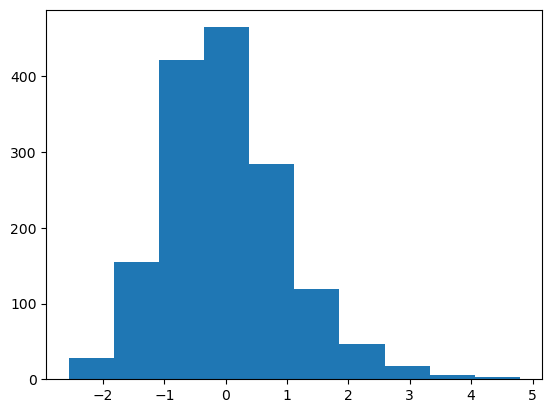

In [112]:
plt.hist(scaler.transform(theta)[:,1])

In [81]:
# create synthetic catalog
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 12345
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

In [24]:
print(x.shape)

(200, 10)


In [123]:
# define a prior
prior = ili.utils.Uniform(low=[0], high=[1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NPE', model='made', hidden_features=20, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=1)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-7
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [124]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 3.


 Training neural network. Epochs trained: 886

INFO:root:Training model 2 / 3.


 Training neural network. Epochs trained: 47 888 epochs.

INFO:root:Training model 3 / 3.


 Training neural network. Epochs trained: 27 48 epochs.

INFO:root:It took 92.96549201011658 seconds to train models.


 Neural network successfully converged after 30 epochs.

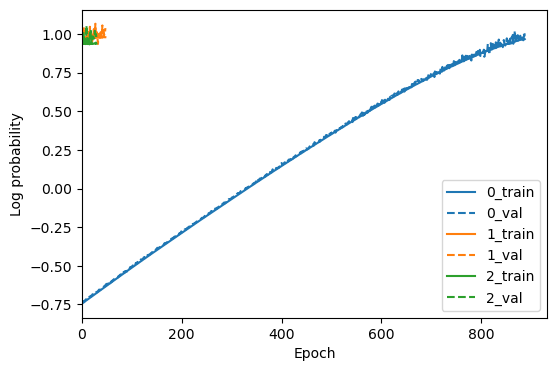

In [125]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [130]:
# Now, SBIRunner returns a custom class instance to be able to pass signature strings
# This class has simply for attributes a NeuralPosteriorEstimate and a string list 
print(posterior_ensemble.signatures)

# choose a random input
#seed_in = 49
#np.random.seed(seed_in)
ind = np.random.randint(len(x))

# generate samples from the posterior using accept/reject sampling
seed_samp = 32
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(theta[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(theta[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

['', '', '']


Drawing 332 posterior samples:   0%|          | 0/332 [00:00<?, ?it/s]

Drawing 335 posterior samples:   0%|          | 0/335 [00:00<?, ?it/s]

Drawing 333 posterior samples:   0%|          | 0/333 [00:00<?, ?it/s]

834


Text(0, 0.5, '$N_{samples}$')

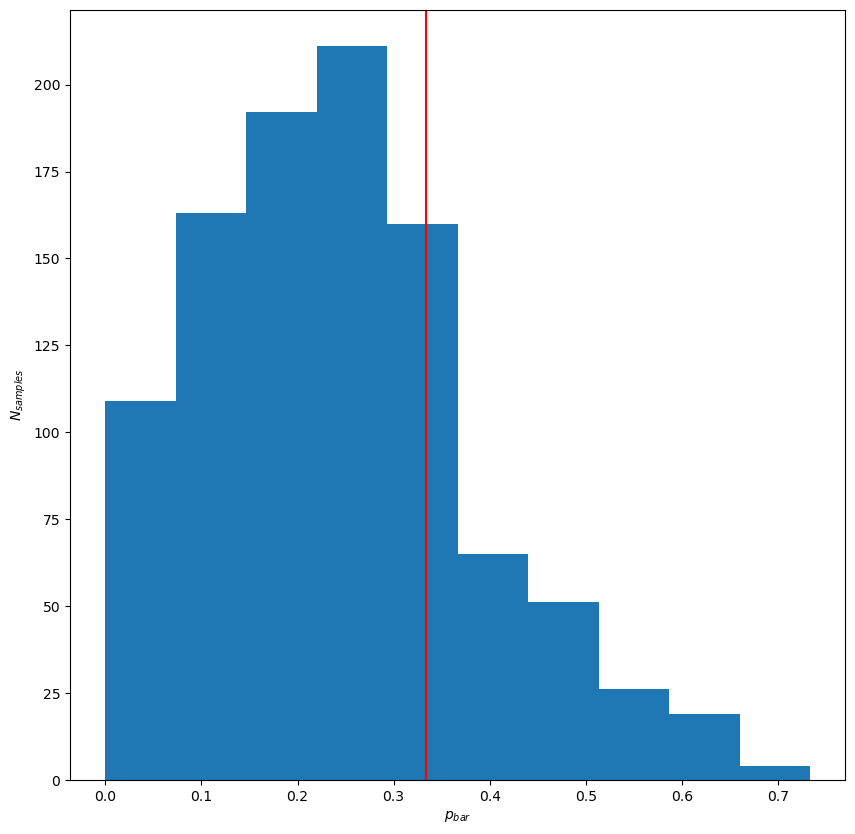

In [131]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 1, figsize=(10,10))

print(ind)
axs.hist(samples[:,0], label='samples')
axs.axvline(x[ind,0], color='red', markersize=10, label='true')
    
#axs.set_aspect('equal')
#axs[i].set_xlim(0,1)
#axs[i].set_ylim(0,1)
axs.set_xlabel('$p_{bar}$')
axs.set_ylabel('$N_{samples}$')


100%|██████████| 100/100 [00:00<00:00, 122.72it/s]


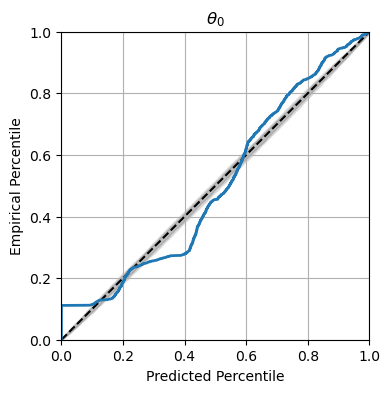

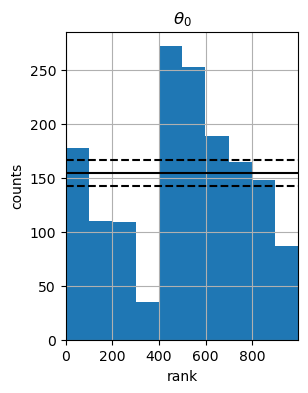

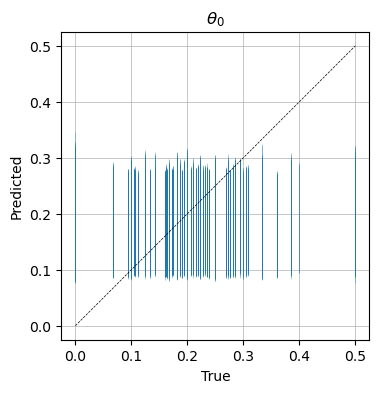

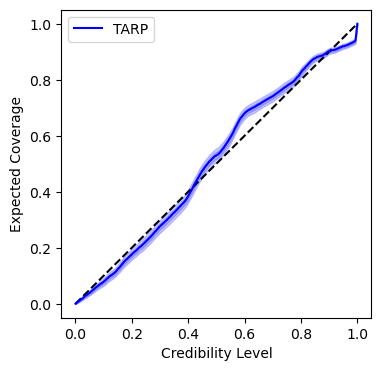

In [132]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=scaler.transform(theta), theta=x
)

100%|██████████| 100/100 [00:00<00:00, 121.23it/s]


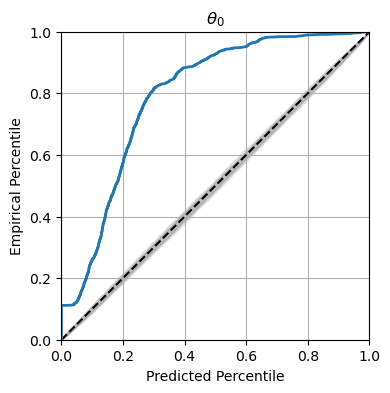

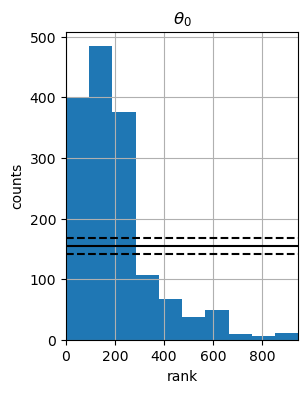

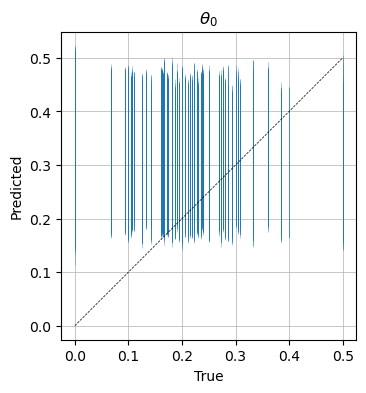

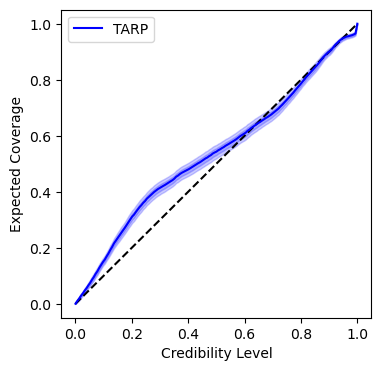

In [136]:
# Drawing samples for each posterior in the ensemble
# First the MAF posterior
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"])

fig = metric(
    posterior=posterior_ensemble.posteriors[1],
    x=theta, theta=x
)

(array([173.,  76., 174., 354., 469., 188.,  71.,  24.,   3.,  14.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 <BarContainer object of 10 artists>)

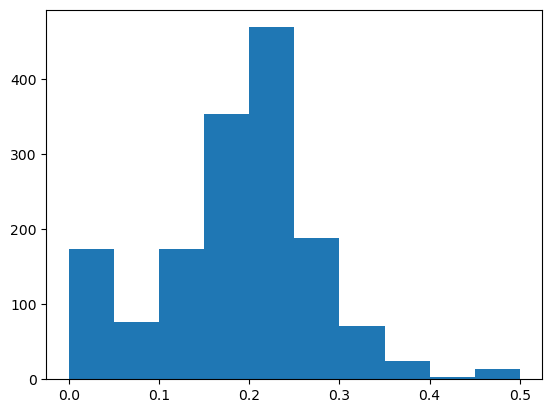

In [137]:
plt.hist(x)